# GEONE - Gaussian Random Fields (GRF) based on FFT - Examples in 3D

Generate gaussian random fields (GRF) following a method based on (block) circulant embedding of the covariance matrix and Fast Fourier Transform (FFT) (to compute discrete Fourier Transform): functions `geone.grf.grf<d>D` and `geone.grf.krige<d>D`.

### References

- J\. W\. Cooley, J\. W\. Tukey (1965) An algorithm for machine calculation of complex Fourier series. Mathematics of Computation 19(90):297-301, [doi:10.2307/2003354](https://dx.doi.org/10.2307/2003354)
- C\. R\. Dietrich, G. N. Newsam (1993) A fast and exact method for multidimensional gaussian stochastic simulations. Water Resources Research 29(8):2861-2869, [doi:10.1029/93WR01070](https://dx.doi.org/10.1029/93WR01070)
- A\. T\. A\. Wood, G. Chan (1994) Simulation of Stationary Gaussian Processes in :math:`[0, 1]^d`. Journal of Computational and Graphical Statistics 3(4):409-432, [doi:10.2307/1390903](https://dx.doi.org/10.2307/1390903)

## Import what is required

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyvista as pv
import time

# import package 'geone'
import geone as gn

In [2]:
# Show version of python and version of geone
import sys 
print(sys.version_info)
print('geone version: ' + gn.__version__)

sys.version_info(major=3, minor=13, micro=7, releaselevel='final', serial=0)
geone version: 1.3.0


In [3]:
pv.set_jupyter_backend('static') # static plots
# pv.set_jupyter_backend('trame')  # 3D-interactive plots

## Covariance model in 3D: class `geone.covModel.covModel3D`

A covariance model is defined by its elementary contributions given as a list of 2-tuples, 
whose the first component is the type given by a string (`nugget`, `spherical`, `exponential`, `gaussian`, ...) and the second component is a dictionary used to pass the required parameters (the weight (`w`), the range (`r`), ...).

Azimuth (`alpha`), dip (`beta`) and plunge (`gamma`) angles can be specified in degrees: the coordinates system Ox'''y''''z''', supporting the axes of the model (ranges), is obtained from the original coordinates system Oxyz as follows:

- Oxyz       -> rotation of angle -alpha around Oz   -> Ox'y'z'
- Ox'y'z'    -> rotation of angle -beta  around Ox'  -> Ox''y''z''
- Ox''y''z'' -> rotation of angle -gamma around Oy'' -> Ox'''y'''z'''

*Note: see the notebook `ex_general_multiGaussian.ipynb` for available covariance models and examples.*

In [4]:
cov_model = gn.covModel.CovModel3D(elem=[
    ('gaussian', {'w':8.5, 'r':[40, 20, 10]}), # elementary contribution
    ('nugget', {'w':0.5})                      # elementary contribution
    ], alpha=-30, beta=-40, gamma=20, name='model-3D example')

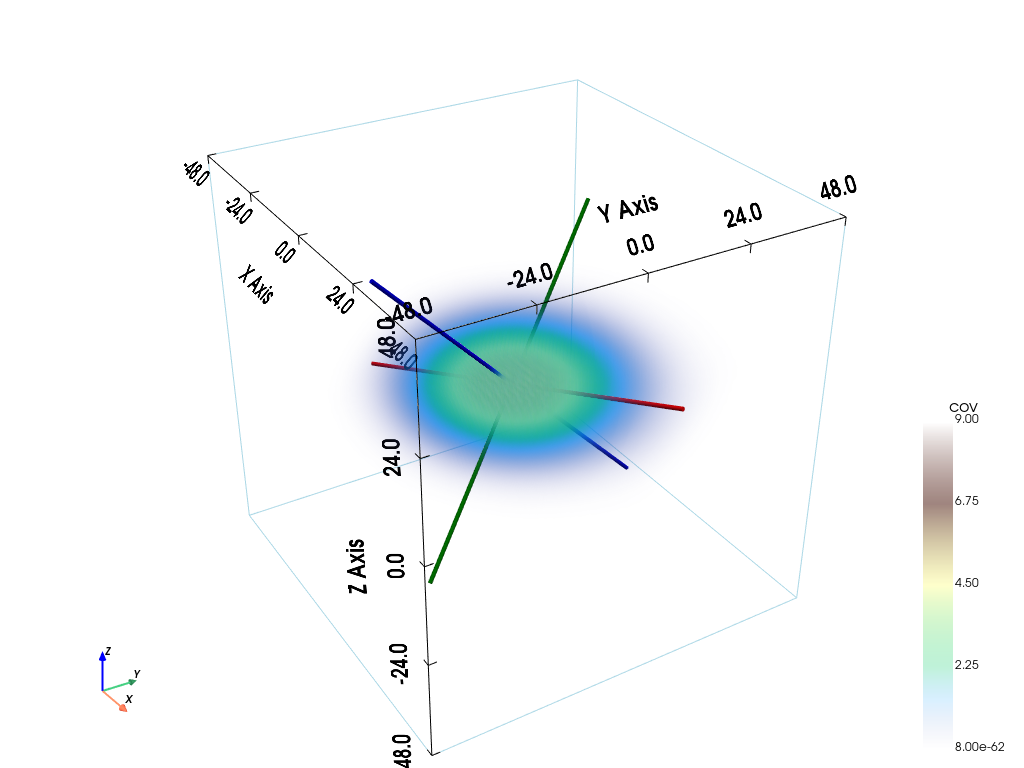

In [5]:
pp = pv.Plotter()
# pp = pv.Plotter(notebook=False) # open a plotter and specifying 'notebook=False'
cov_model.plot_model3d_volume(plotter=pp)
cpos = pp.show(cpos=(165, -100, 115), return_cpos=True)

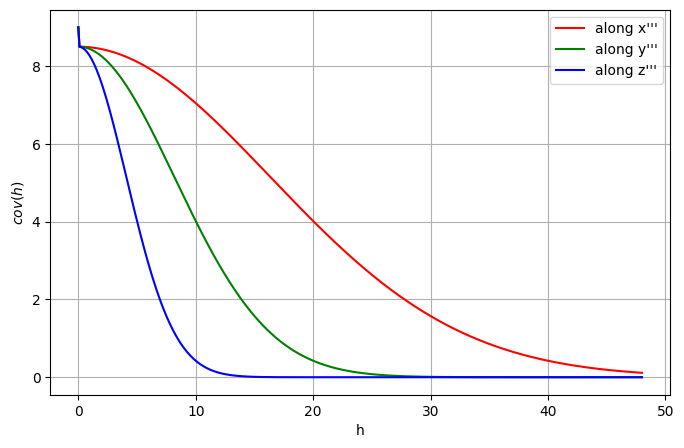

In [6]:
plt.figure(figsize=(8, 5))
cov_model.plot_model_curves()
plt.show()

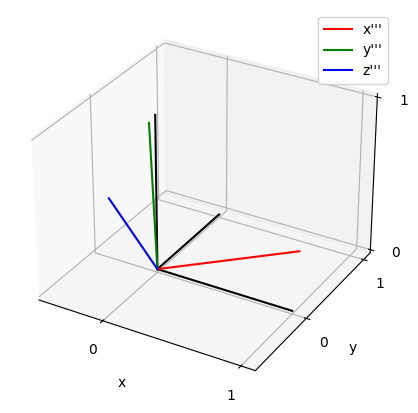

In [7]:
cov_model.plot_mrot(figsize=(5,5))

## GRFs - simulation and estimation in 3D
The following functions are used:

- `geone.grf.grf3D` for simulation 3D
- `geone.grf.krige3D` for estimation 3D

The algorithms are based on Fast Fourier Transform (FFT), then periodic fields are generated (for simulation / estimation). Hence, an extended simulation grid is used and then cropped after the simulation. The extension should be large enough in order to avoid wrong correlations, i.e. correlations across opposite borders of the grid, or correlations between two nodes regarding both distances between them (with respect to the periodic grid).

An appropriate extension is automatically computed by the function `geone.grf.grf3D` based on the covariance model class passed as first argument. However, the minimal extension along each axis (x, y, and z) can be given explicitly with the keyword argument `extensionMin`.

Note that a covariance function can be passed as first argument (in the example below, the function `cov_model.func()` instead of the class `cov_model`). In this situation, an appropriate minimal extension can be computed by the function `extension_min` for each axis (i.e. `[geone.grf.extension_min(r, n, s) for r, n, s in zip(cov_model.rxyz(), (nx, ny, nz), (sx, sy, sz))]`), and then passed to the GRF simulator `geone.grf.grf3D` via the keyword argument `extensionMin`.

*Notes.*
When passing the covariance model class as first argument, the extension is computed based on the range of the covariance. If the results show artefacts or unexpected features (this can happen when using Gaussian covariance model), one may try to fix the problem by increasing the extension. To do so, a factor (greather than one) can be specified via the keyword argument `rangeFactorForExtensionMin`: the range will be multiplied by this factor before computing the extension.

*Remark:* the keyword argument `verbose` allows to control what is displayed, `verbose=0`: minimal display, `verbose=1`: only error(s) (if any), `verbose=2` (default): error(s) and warning(s) encountered, `verbose=3`: error(s) and warning(s) encountered, and additional information.

### Data aggregation in grid
As the simulation / estimation is done in a grid, the conditioning data are first aggregated in the grid cells, i.e. data points falling in the same grid cell are aggregated in one unique value at the cell centre, using the operation specified by the parameter (keyword argument) `aggregate_data_op`, a string that can be `'sgs'` (i.e. function `geone.covModel.sgs` is used, for simulation only), `'krige'` (i.e. function `geone.covModel.krige` is used, default for estimation), `'min'`, `'max'`, `'mean'` (i.e. function `numpy.<aggregate_data_op>` is used), etc. Furthermore, the parameter (keyword argument) `aggregate_data_op_kwargs` is a dictionary that contains keyword arguments passed to the operation specified by `aggregate_data_op`.

If `aggregate_data_op='krige'` or `aggregate_data_op='sgs'` is specified, a covariance model (not directly a covariance function) has to be passed as first argument. 

*Note:* for simulation, by specifiying `aggregate_data_op='sgs'` (default), the aggregation is done for each realization (simulation), i.e. each simulation in the grid starts with a new set of values in conditioning grid cells.

### Alternative: wrapper `geone.multiGaussian.multiGaussianRun`

The function `geone.multiGaussian.multiGaussianRun` can be used as a wrapper; with keyword arguments:

- `mode='simulation', algo='fft'`: wrapper for `geone.grf.grf<d>D`
- `mode='estimation', algo='fft'`: wrapper for `geone.grf.krige<d>D`

where the dimension `<d>` is automatically detected. Note also that the function `geone.multiGaussian.multiGaussianRun` allows to choose the "format" of the output by the keyword argument `output_mode`:

- `output_mode='array'`: an numpy array is returned
- `output_mode='img'`: an "image" (class `geone.img.Img`) is returned

## GRFs - 3D
Define the simulation grid.

In [8]:
nx, ny, nz = 85, 56, 34  # number of cells
sx, sy, sz = 1.0, 1.0, 1.0  # cell unit
ox, oy, oz = 0.0, 0.0, 0.0  # origin

dimension = [nx, ny, nz]
spacing = [sx, sy, sz]
origin = [ox, oy, oz]

## Case A - Unconditional 

### Simulation - case A
Set the number of realizations, the seed and launch the (unconditional) simulations.

In [9]:
nreal = 100
np.random.seed(123)
t1 = time.time() # start time
sim3Da = gn.grf.grf3D(cov_model, dimension, spacing, origin, nreal=nreal)
# sim3Da = gn.grf.grf3D(cov_model, dimension, spacing, origin, nreal=nreal, verbose=3)
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

Elapsed time: 3.4 sec


In [10]:
# %%script false --no-raise-error # skip this cell! (comment this line to run the cell)

# Alternative:
nreal = 100
np.random.seed(123)
t1 = time.time() # start time
out = gn.multiGaussian.multiGaussianRun(cov_model, dimension, spacing, origin, 
                                        mode='simulation', algo='fft', output_mode='array',
                                        nreal=nreal)
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

# Same results:
np.all(out == sim3Da) # should be True

grf3D: Preliminary computation...
grf3D: Computing circulant embedding...
grf3D: embedding dimension: 128 x 128 x 64
grf3D: Computing FFT of circulant matrix...
Elapsed time: 4 sec


np.True_

The result is a 4d array of size `nreal` by `nz` by `ny` by `nx`:

In [11]:
sim3Da.shape

(100, 34, 56, 85)

Fill an image (`geone.img.Img` class) with all realizations (for display, see below), and delete the array sim3Da.

In [12]:
sim3Da_img = gn.img.Img(nx, ny, nz, sx, sy, sz, ox, oy, oz, nv=nreal, val=sim3Da)
del(sim3Da)

Compute the mean and the standard deviation over the realizations (pixel-wise).

In [13]:
sim3Da_mean_img = gn.img.imageContStat(sim3Da_img, op='mean') # pixel-wise mean
sim3Da_std_img = gn.img.imageContStat(sim3Da_img, op='std')   # pixel-wise standard deviation
# # Or:
# sim3Da_mean = np.mean(sim3Da, axis=0)
# sim3Da_std = np.std(sim3Da, axis=0)
# # and then fill new image with results

### Kriging - case A
Compute (simple) kriging estimates and standard deviation.

*Note: not really interesting here, without any data.*

In [14]:
t1 = time.time() # start time
krig3Da, krig3Da_std = gn.grf.krige3D(cov_model, dimension, spacing, origin)
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

# Fill an image with two variables : kriging estimates and kriging std
krig3Da_img = gn.img.Img(nx, ny, nz, sx, sy, sz, ox, oy, oz, nv=2, val=np.array((krig3Da, krig3Da_std)))


Elapsed time: 0.00067 sec


In [15]:
# %%script false --no-raise-error # skip this cell! (comment this line to run the cell)

# Alternative:
t1 = time.time() # start time
np.random.seed(123)
out = gn.multiGaussian.multiGaussianRun(cov_model, dimension, spacing, origin,
                                        mode='estimation', algo='fft', output_mode='array')
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

# Same results:
print(f'Same results ? {np.allclose(out, np.array((krig3Da, krig3Da_std)))}') # should be True

Elapsed time: 0.0035 sec
Same results ? True


In [16]:
del(krig3Da, krig3Da_std)

### Plot results - case A

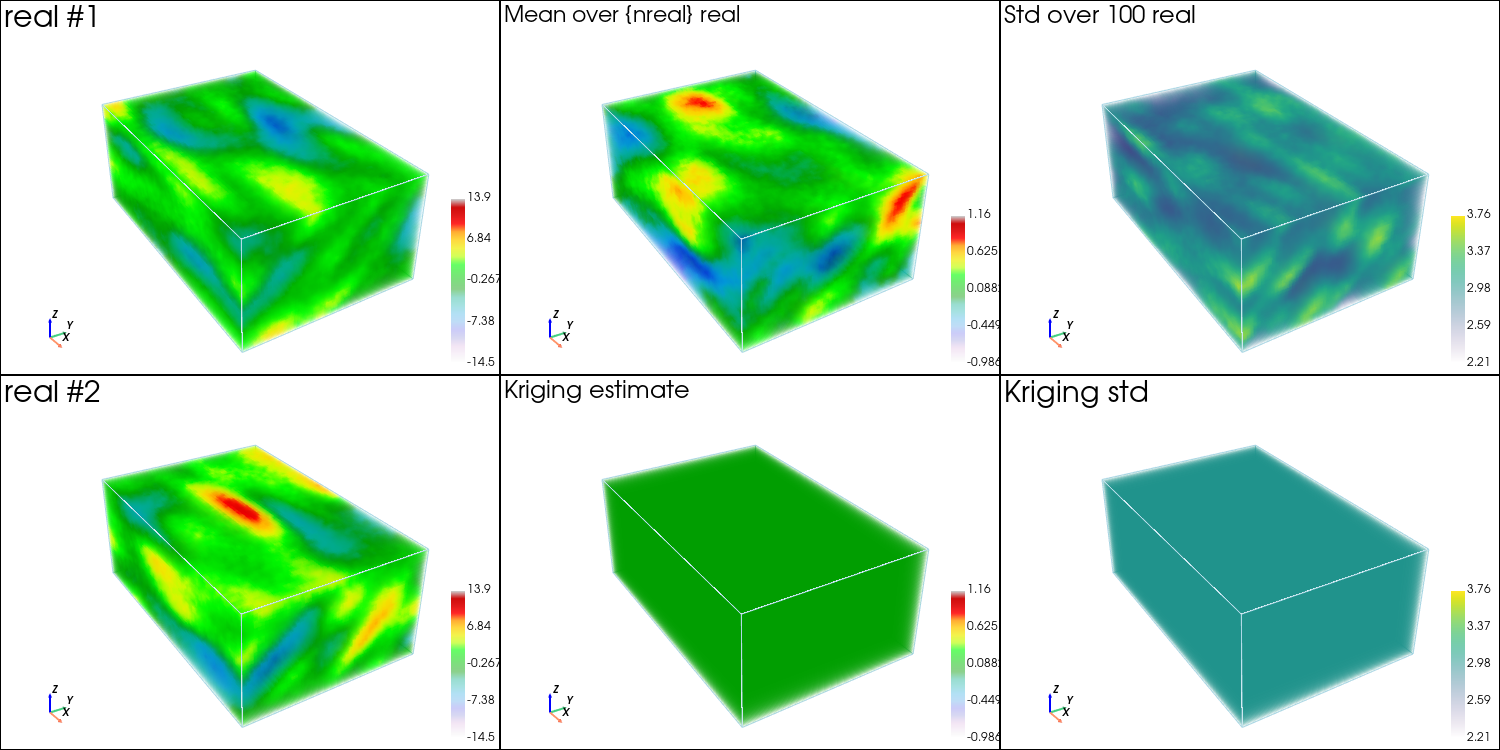

In [17]:
# Color settings
cmap = 'nipy_spectral'
cmin = sim3Da_img.val.min()
cmax = sim3Da_img.val.max()

cmap_mean = 'nipy_spectral'
cmin_mean = min(sim3Da_mean_img.val.min(), krig3Da_img.val[0].min())
cmax_mean = max(sim3Da_mean_img.val.max(), krig3Da_img.val[0].max())

cmap_std = 'viridis'
cmin_std = min(sim3Da_std_img.val.min(), krig3Da_img.val[1].min())
cmax_std = max(sim3Da_std_img.val.max(), krig3Da_img.val[1].max())

# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(2, 3), window_size=(1500, 750), notebook=False)
# ... inline
pp = pv.Plotter(shape=(2, 3), window_size=(1500, 750))

# 2 first reals
for i in (0, 1):
    pp.subplot(i, 0)
    gn.imgplot3d.drawImage3D_volume(
        sim3Da_img, iv=i, 
        plotter=pp,
        cmap=cmap, cmin=cmin, cmax=cmax,
        text=f'real #{i+1}',
        text_kwargs={'font_size':12},
        scalar_bar_kwargs={'title':i*' ', 'vertical':True, 'label_font_size':12})
        # note: scalar bar title : set new one for each plot to show the scalar bar...

# mean of all real
pp.subplot(0, 1)
gn.imgplot3d.drawImage3D_volume(
    sim3Da_mean_img, 
    plotter=pp,
    cmap=cmap_mean, cmin=cmin_mean, cmax=cmax_mean,
    text='Mean over {nreal} real',
    text_kwargs={'font_size':12},
    scalar_bar_kwargs={'title':2*' ', 'vertical':True, 'label_font_size':12})

# standard deviation of all real
pp.subplot(0, 2)
gn.imgplot3d.drawImage3D_volume(
    sim3Da_std_img, 
    plotter=pp,
    cmap=cmap_std, cmin=cmin_std, cmax=cmax_std,
    text=f'Std over {nreal} real',
    text_kwargs={'font_size':12},
    scalar_bar_kwargs={'title':3*' ', 'vertical':True, 'label_font_size':12})

# kriging estimate
pp.subplot(1, 1)
gn.imgplot3d.drawImage3D_volume(
    krig3Da_img, iv=0, 
    plotter=pp,
    cmap=cmap_mean, cmin=cmin_mean, cmax=cmax_mean,
    text=f'Kriging estimate',
    text_kwargs={'font_size':12},
    scalar_bar_kwargs={'title':4*' ', 'vertical':True, 'label_font_size':12})

# kriging std
pp.subplot(1, 2)
gn.imgplot3d.drawImage3D_volume(
    krig3Da_img, iv=1, 
    plotter=pp,
    cmap=cmap_std, cmin=cmin_std, cmax=cmax_std,
    text=f'Kriging std',
    text_kwargs={'font_size':12},
    scalar_bar_kwargs={'title':5*' ', 'vertical':True, 'label_font_size':12})

pp.link_views()

cpos = pp.show(cpos=(165, -100, 115), return_cpos=True) # position of the camera can be specified

Plot slices orthogonal to each axis x, y, z.

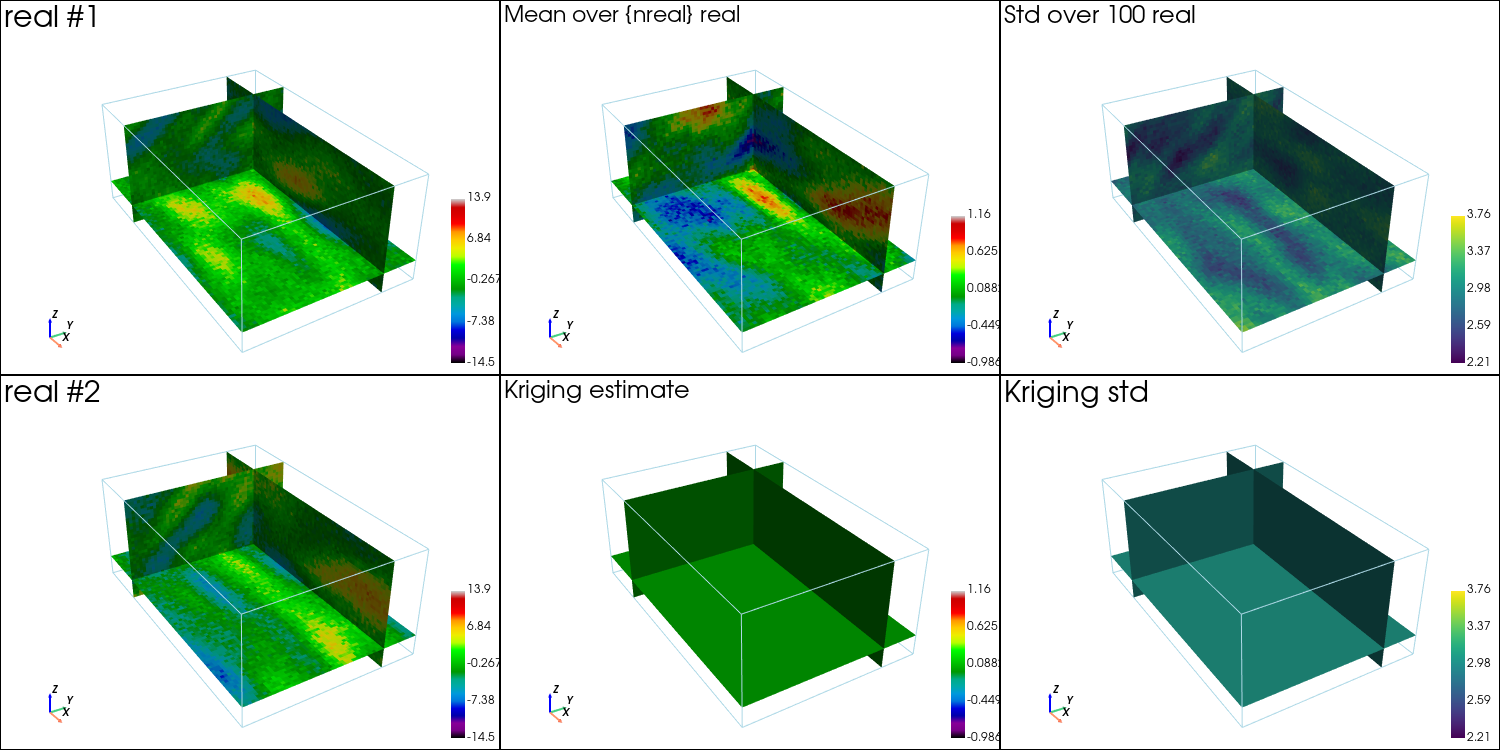

In [18]:
# Plot slices
# -----------
# # Color settings
# cmap = 'nipy_spectral'
# cmin = sim3Da_img.val.min()
# cmax = sim3Da_img.val.max()

# cmap_mean = 'nipy_spectral'
# cmin_mean = min(sim3Da_mean_img.val.min(), krig3Da_img.val[0].min())
# cmax_mean = max(sim3Da_mean_img.val.max(), krig3Da_img.val[0].max())

# cmap_std = 'viridis'
# cmin_std = min(sim3Da_std_img.val.min(), krig3Da_img.val[1].min())
# cmax_std = max(sim3Da_std_img.val.max(), krig3Da_img.val[1].max())

# Set default slices
slice_normal_x = sim3Da_img.x()[int(0.2*nx)]
slice_normal_y = sim3Da_img.y()[int(0.8*ny)]
slice_normal_z = sim3Da_img.z()[int(0.2*nz)]

# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(2, 3), window_size=(1500, 750), notebook=False)
# ... inline
pp = pv.Plotter(shape=(2, 3), window_size=(1500, 750))

# 2 first reals
for i in (0, 1):
    pp.subplot(i, 0)
    gn.imgplot3d.drawImage3D_slice(
        sim3Da_img, iv=i, 
        plotter=pp,
        slice_normal_x=slice_normal_x,
        slice_normal_y=slice_normal_y,
        slice_normal_z=slice_normal_z,
        cmap=cmap, cmin=cmin, cmax=cmax,
        text=f'real #{i+1}',
        text_kwargs={'font_size':12},
        scalar_bar_kwargs={'title':i*' ', 'vertical':True, 'label_font_size':12})
        # note: scalar bar title : set new one for each plot to show the scalar bar...

# mean of all real
pp.subplot(0, 1)
gn.imgplot3d.drawImage3D_slice(
    sim3Da_mean_img, 
    plotter=pp,
    slice_normal_x=slice_normal_x,
    slice_normal_y=slice_normal_y,
    slice_normal_z=slice_normal_z,
    cmap=cmap_mean, cmin=cmin_mean, cmax=cmax_mean,
    text='Mean over {nreal} real',
    text_kwargs={'font_size':12},
    scalar_bar_kwargs={'title':2*' ', 'vertical':True, 'label_font_size':12})

# standard deviation of all real
pp.subplot(0, 2)
gn.imgplot3d.drawImage3D_slice(
    sim3Da_std_img, 
    plotter=pp,
    slice_normal_x=slice_normal_x,
    slice_normal_y=slice_normal_y,
    slice_normal_z=slice_normal_z,
    cmap=cmap_std, cmin=cmin_std, cmax=cmax_std,
    text=f'Std over {nreal} real',
    text_kwargs={'font_size':12},
    scalar_bar_kwargs={'title':3*' ', 'vertical':True, 'label_font_size':12})

# kriging estimate
pp.subplot(1, 1)
gn.imgplot3d.drawImage3D_slice(
    krig3Da_img, iv=0, 
    plotter=pp,
    slice_normal_x=slice_normal_x,
    slice_normal_y=slice_normal_y,
    slice_normal_z=slice_normal_z,
    cmap=cmap_mean, cmin=cmin_mean, cmax=cmax_mean,
    text=f'Kriging estimate',
    text_kwargs={'font_size':12},
    scalar_bar_kwargs={'title':4*' ', 'vertical':True, 'label_font_size':12})

# kriging std
pp.subplot(1, 2)
gn.imgplot3d.drawImage3D_slice(
    krig3Da_img, iv=1, 
    plotter=pp,
    slice_normal_x=slice_normal_x,
    slice_normal_y=slice_normal_y,
    slice_normal_z=slice_normal_z,
    cmap=cmap_std, cmin=cmin_std, cmax=cmax_std,
    text=f'Kriging std',
    text_kwargs={'font_size':12},
    scalar_bar_kwargs={'title':5*' ', 'vertical':True, 'label_font_size':12})

pp.link_views()

cpos = pp.show(cpos=(165, -100, 115), return_cpos=True) # position of the camera can be specified

### Comparison of mean and standard deviation of all realizations with kriging results - case A

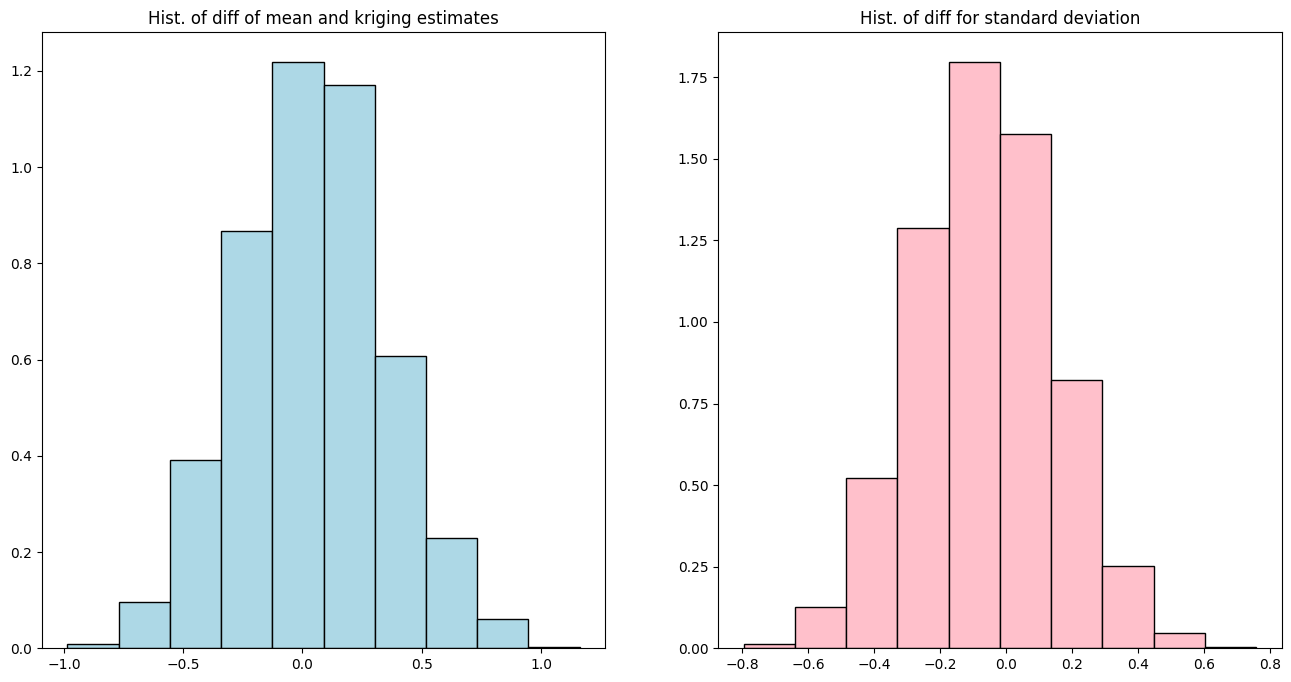

In [19]:
plt.subplots(1, 2, figsize=(16,8))

# Histogram of mean of all real - kriging estimates
plt.subplot(1, 2, 1)
plt.hist(sim3Da_mean_img.val.reshape(-1) - krig3Da_img.val[0].reshape(-1), 
         density=True, color='lightblue', edgecolor='black')
plt.title('Hist. of diff of mean and kriging estimates')

# Histogram of std of all real - kriging std
# kriging standard deviation
plt.subplot(1, 2, 2)
plt.hist(sim3Da_std_img.val.reshape(-1) - krig3Da_img.val[1].reshape(-1), 
         density=True, color='pink', edgecolor='black')
plt.title('Hist. of diff for standard deviation')

plt.show()

## Case B - Conditional
Define (hard) data.

In [20]:
# Data
x = np.array([[ 10.25,  20.14,  3.15], 
              [ 40.50,  10.50, 10.50], 
              [ 30.65,  40.53, 20.24],
              [ 30.18,  30.14, 30.98]]) # data locations (real coordinates)
v = [ -3.,  2.,   5.,  -1.]  # data values

### Simulation - case B
Set the number of realizations, the seed and launch the simulations.

In [21]:
nreal = 100
np.random.seed(123)
t1 = time.time() # start time
sim3Db = gn.grf.grf3D(cov_model, dimension, spacing, origin, x=x, v=v, nreal=nreal)
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

# Fill image with result, and compute statistics
sim3Db_img = gn.img.Img(nx, ny, nz, sx, sy, sz, ox, oy, oz, nv=nreal, val=sim3Db)
del(sim3Db)
sim3Db_mean_img = gn.img.imageContStat(sim3Db_img, op='mean') # pixel-wise mean
sim3Db_std_img = gn.img.imageContStat(sim3Db_img, op='std')   # pixel-wise standard deviation

Elapsed time: 13 sec


In [22]:
# %%script false --no-raise-error # skip this cell! (comment this line to run the cell)

# Alternative:
np.random.seed(123)
t1 = time.time() # start time
out = gn.multiGaussian.multiGaussianRun(cov_model, dimension, spacing, origin, 
                                        x=x, v=v,
                                        mode='simulation', algo='fft', output_mode='array',
                                        nreal=nreal)
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

# Same results:
print(f'Same results ? {np.allclose(out, sim3Db_img.val[:, :, :, :])}') # should be True

grf3D: Preliminary computation...
grf3D: Computing circulant embedding...
grf3D: embedding dimension: 128 x 128 x 64
grf3D: Computing FFT of circulant matrix...
grf3D: Treatment of conditioning data...
grf3D: Computing covariance matrix (rAA) for conditioning locations...
grf3D: Computing index in the embedding grid for non-conditioning / conditioning locations...
Elapsed time: 9 sec
Same results ? True


### Kriging - case B
Compute (simple) kriging estimates and standard deviation.

In [23]:
t1 = time.time() # start time
krig3Db, krig3Db_std = gn.grf.krige3D(cov_model, dimension, spacing, origin, x=x, v=v)
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

# Fill an image with two variables : kriging estimates and kriging std
krig3Db_img = gn.img.Img(nx, ny, nz, sx, sy, sz, ox, oy, oz, nv=2, val=np.array((krig3Db, krig3Db_std)))
del(krig3Db, krig3Db_std)


Elapsed time: 0.3 sec


In [24]:
# %%script false --no-raise-error # skip this cell! (comment this line to run the cell)

# Alternative:
t1 = time.time() # start time
np.random.seed(123)
out = gn.multiGaussian.multiGaussianRun(cov_model, dimension, spacing, origin,
                                        x=x, v=v,
                                        mode='estimation', algo='fft', output_mode='array')
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

# Same results:
print(f'Same results ? {np.allclose(out, krig3Db_img.val[:, :, :, :])}') # should be True

krige3D: Computing circulant embedding...
krige3D: embedding dimension: 128 x 128 x 64
krige3D: Computing FFT of circulant matrix...
krige3D: Computing covariance matrix (rAA) for conditioning locations...
krige3D: Computing covariance matrix (rBA) for non-conditioning / conditioning locations...
krige3D: Computing rBA * rAA^(-1)...
krige3D: computing kriging estimates...
krige3D: computing kriging standard deviation ...
Elapsed time: 0.29 sec
Same results ? True


### Plot results - case B

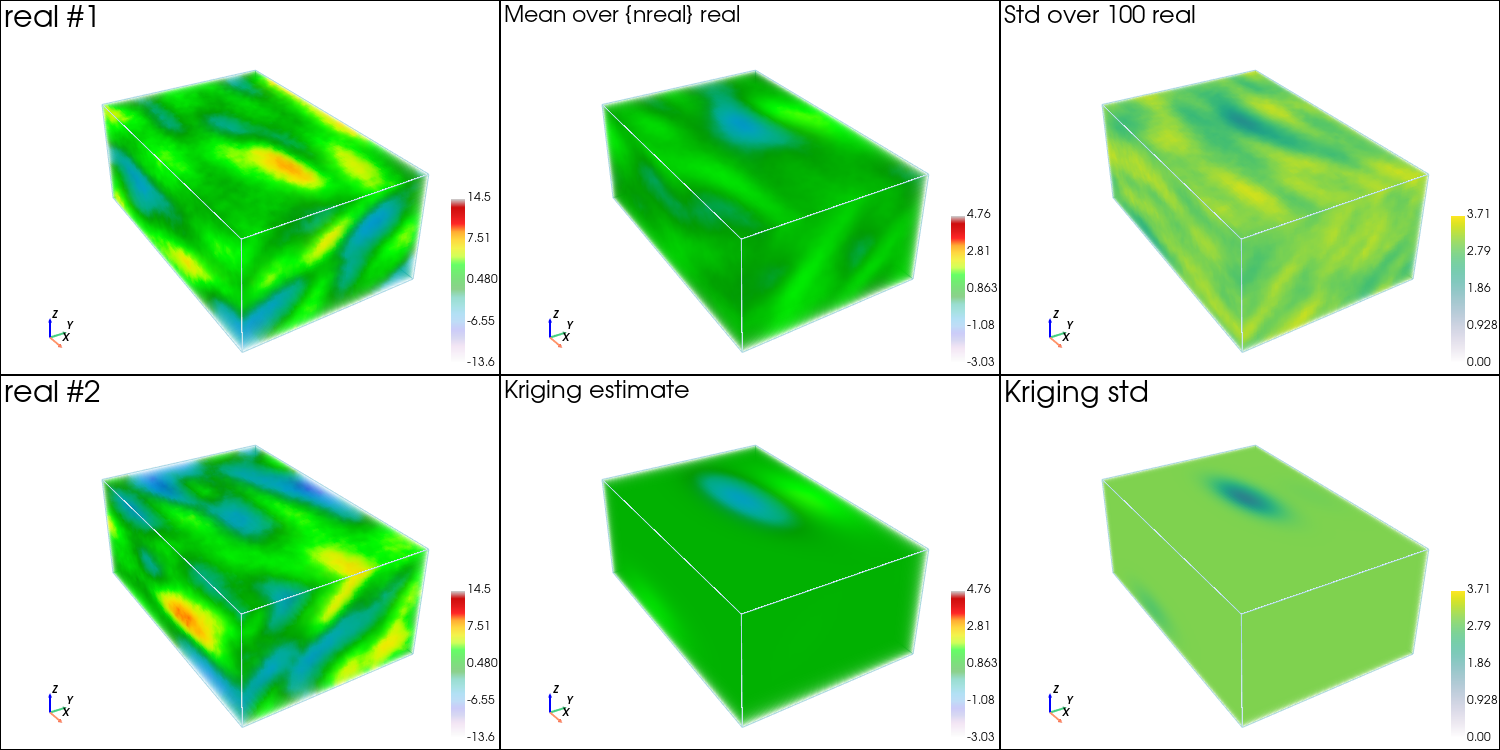

In [25]:
# Color settings
cmap = 'nipy_spectral'
cmin = sim3Db_img.val.min()
cmax = sim3Db_img.val.max()

cmap_mean = 'nipy_spectral'
cmin_mean = min(sim3Db_mean_img.val.min(), krig3Db_img.val[0].min())
cmax_mean = max(sim3Db_mean_img.val.max(), krig3Db_img.val[0].max())

cmap_std = 'viridis'
cmin_std = min(sim3Db_std_img.val.min(), krig3Db_img.val[1].min())
cmax_std = max(sim3Db_std_img.val.max(), krig3Db_img.val[1].max())

# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(2, 3), window_size=(1500, 750), notebook=False)
# ... inline
pp = pv.Plotter(shape=(2, 3), window_size=(1500, 750))

# 2 first reals
for i in (0, 1):
    pp.subplot(i, 0)
    gn.imgplot3d.drawImage3D_volume(
        sim3Db_img, iv=i, 
        plotter=pp,
        cmap=cmap, cmin=cmin, cmax=cmax,
        text=f'real #{i+1}',
        text_kwargs={'font_size':12},
        scalar_bar_kwargs={'title':i*' ', 'vertical':True, 'label_font_size':12})
        # note: scalar bar title : set new one for each plot to show the scalar bar...

# mean of all real
pp.subplot(0, 1)
gn.imgplot3d.drawImage3D_volume(
    sim3Db_mean_img, 
    plotter=pp,
    cmap=cmap_mean, cmin=cmin_mean, cmax=cmax_mean,
    text='Mean over {nreal} real',
    text_kwargs={'font_size':12},
    scalar_bar_kwargs={'title':2*' ', 'vertical':True, 'label_font_size':12})

# standard deviation of all real
pp.subplot(0, 2)
gn.imgplot3d.drawImage3D_volume(
    sim3Db_std_img, 
    plotter=pp,
    cmap=cmap_std, cmin=cmin_std, cmax=cmax_std,
    text=f'Std over {nreal} real',
    text_kwargs={'font_size':12},
    scalar_bar_kwargs={'title':3*' ', 'vertical':True, 'label_font_size':12})

# kriging estimate
pp.subplot(1, 1)
gn.imgplot3d.drawImage3D_volume(
    krig3Db_img, iv=0, 
    plotter=pp,
    cmap=cmap_mean, cmin=cmin_mean, cmax=cmax_mean,
    text=f'Kriging estimate',
    text_kwargs={'font_size':12},
    scalar_bar_kwargs={'title':4*' ', 'vertical':True, 'label_font_size':12})

# kriging std
pp.subplot(1, 2)
gn.imgplot3d.drawImage3D_volume(
    krig3Db_img, iv=1, 
    plotter=pp,
    cmap=cmap_std, cmin=cmin_std, cmax=cmax_std,
    text=f'Kriging std',
    text_kwargs={'font_size':12},
    scalar_bar_kwargs={'title':5*' ', 'vertical':True, 'label_font_size':12})

pp.link_views()

cpos = pp.show(cpos=(165, -100, 115), return_cpos=True) # position of the camera can be specified

Plot slices orthogonal to each axis x, y, z, ang going through the first data point, and plot the data points.

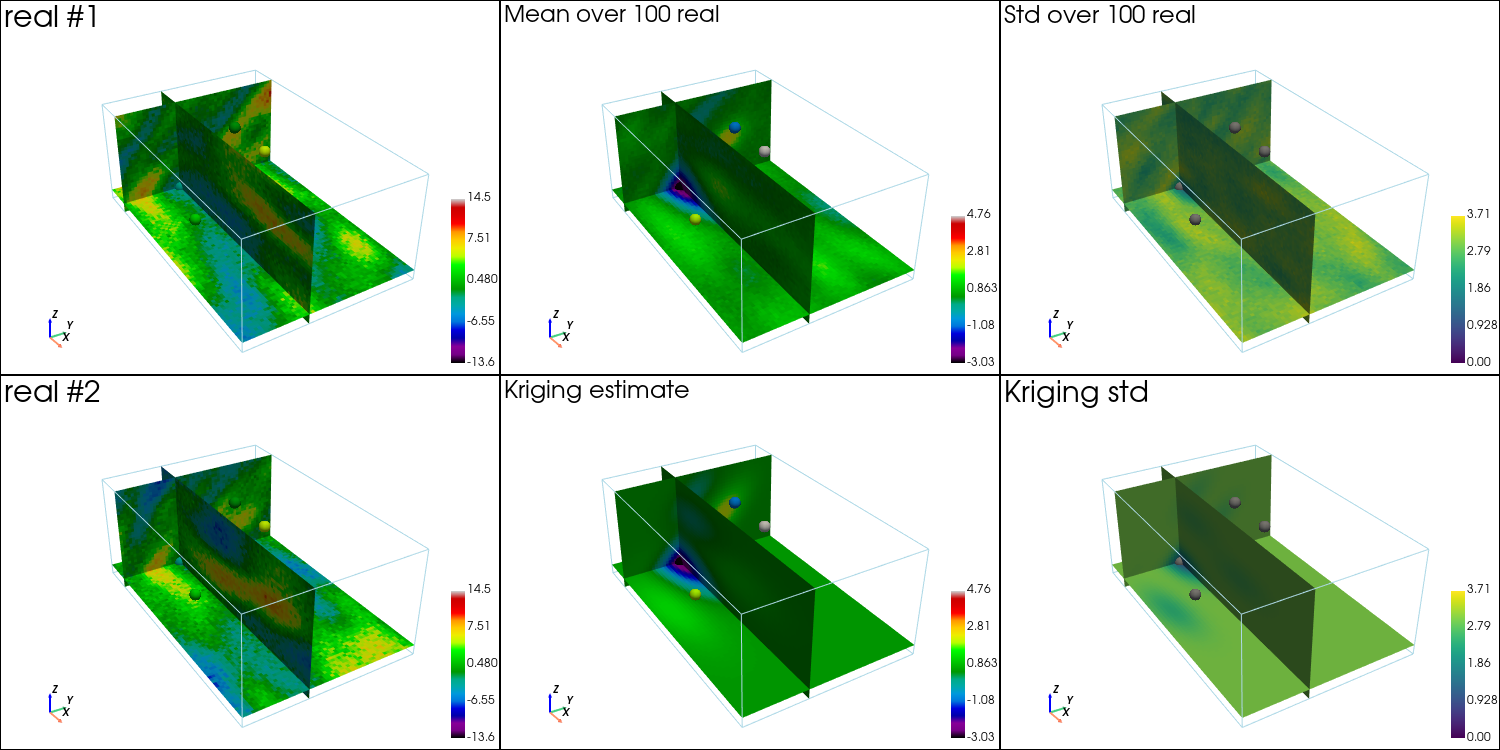

In [26]:
# Plot slices (with data points)
# ------------------------------
# # Color settings
# cmap = 'nipy_spectral'
# cmin = sim3Db_img.val.min()
# cmax = sim3Db_img.val.max()

# cmap_mean = 'nipy_spectral'
# cmin_mean = min(sim3Db_mean_img.val.min(), krig3Db_img.val[0].min())
# cmax_mean = max(sim3Db_mean_img.val.max(), krig3Db_img.val[0].max())

# cmap_std = 'viridis'
# cmin_std = min(sim3Db_std_img.val.min(), krig3Db_img.val[1].min())
# cmax_std = max(sim3Db_std_img.val.max(), krig3Db_img.val[1].max())

# Settings for plotting data
if x is not None:
    # Get colors for conditioning data according to their value and color settings
    data_points_col      = gn.imgplot.get_colors_from_values(v, cmap=cmap, cmin=cmin, cmax=cmax) 
    data_points_mean_col = gn.imgplot.get_colors_from_values(v, cmap=cmap_mean, cmin=cmin_mean, cmax=cmax_mean) 

    # Set points to be plotted
    data_points = pv.PolyData(x)
    data_points['colors'] = data_points_col

    data_points_mean = pv.PolyData(x)
    data_points_mean['colors'] = data_points_mean_col

    # Set slices through data of index j
    j = 0
    slice_normal_x = x[j,0]
    slice_normal_y = x[j,1]
    slice_normal_z = x[j,2]
else:
    # Set default slices
    slice_normal_x = sim3Db_img.x()[int(0.2*nx)]
    slice_normal_y = sim3Db_img.y()[int(0.8*ny)]
    slice_normal_z = sim3Db_img.z()[int(0.2*nz)]

# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(2, 3), window_size=(1500, 750), notebook=False)
# ... inline
pp = pv.Plotter(shape=(2, 3), window_size=(1500, 750))

# 2 first reals
for i in (0, 1):
    pp.subplot(i, 0)
    gn.imgplot3d.drawImage3D_slice(
        sim3Db_img, iv=i, 
        plotter=pp,
        slice_normal_x=slice_normal_x,
        slice_normal_y=slice_normal_y,
        slice_normal_z=slice_normal_z,
        cmap=cmap, cmin=cmin, cmax=cmax,
        text=f'real #{i+1}',
        text_kwargs={'font_size':12},
        scalar_bar_kwargs={'title':i*' ', 'vertical':True, 'label_font_size':12})
        # note: scalar bar title : set new one for each plot to show the scalar bar...
    if x is not None:
        pp.add_mesh(data_points, rgb=True, point_size=12., render_points_as_spheres=True) # add data points

# mean of all real
pp.subplot(0, 1)
gn.imgplot3d.drawImage3D_slice(
    sim3Db_mean_img, 
    plotter=pp,
    slice_normal_x=slice_normal_x,
    slice_normal_y=slice_normal_y,
    slice_normal_z=slice_normal_z,
    cmap=cmap_mean, cmin=cmin_mean, cmax=cmax_mean,
    text=f'Mean over {nreal} real',
    text_kwargs={'font_size':12},
    scalar_bar_kwargs={'title':2*' ', 'vertical':True, 'label_font_size':12})
if x is not None:
    pp.add_mesh(data_points_mean, rgb=True, point_size=12., render_points_as_spheres=True) # add data points

# standard deviation of all real
pp.subplot(0, 2)
gn.imgplot3d.drawImage3D_slice(
    sim3Db_std_img, 
    plotter=pp,
    slice_normal_x=slice_normal_x,
    slice_normal_y=slice_normal_y,
    slice_normal_z=slice_normal_z,
    cmap=cmap_std, cmin=cmin_std, cmax=cmax_std,
    text=f'Std over {nreal} real',
    text_kwargs={'font_size':12},
    scalar_bar_kwargs={'title':3*' ', 'vertical':True, 'label_font_size':12})
if x is not None:
    pp.add_mesh(data_points, color='gray', point_size=12., render_points_as_spheres=True) # add data points

# kriging estimate
pp.subplot(1, 1)
gn.imgplot3d.drawImage3D_slice(
    krig3Db_img, iv=0, 
    plotter=pp,
    slice_normal_x=slice_normal_x,
    slice_normal_y=slice_normal_y,
    slice_normal_z=slice_normal_z,
    cmap=cmap_mean, cmin=cmin_mean, cmax=cmax_mean,
    text=f'Kriging estimate',
    text_kwargs={'font_size':12},
    scalar_bar_kwargs={'title':4*' ', 'vertical':True, 'label_font_size':12})
if x is not None:
    pp.add_mesh(data_points_mean, rgb=True, point_size=12., render_points_as_spheres=True) # add data points

# kriging std
pp.subplot(1, 2)
gn.imgplot3d.drawImage3D_slice(
    krig3Db_img, iv=1, 
    plotter=pp,
    slice_normal_x=slice_normal_x,
    slice_normal_y=slice_normal_y,
    slice_normal_z=slice_normal_z,
    cmap=cmap_std, cmin=cmin_std, cmax=cmax_std,
    text=f'Kriging std',
    text_kwargs={'font_size':12},
    scalar_bar_kwargs={'title':5*' ', 'vertical':True, 'label_font_size':12})
if x is not None:
    pp.add_mesh(data_points, color='gray', point_size=12., render_points_as_spheres=True) # add data points

pp.link_views()

cpos = pp.show(cpos=(165, -100, 115), return_cpos=True) # position of the camera can be specified

### Comparison of mean and standard deviation of all realizations with kriging results - case B

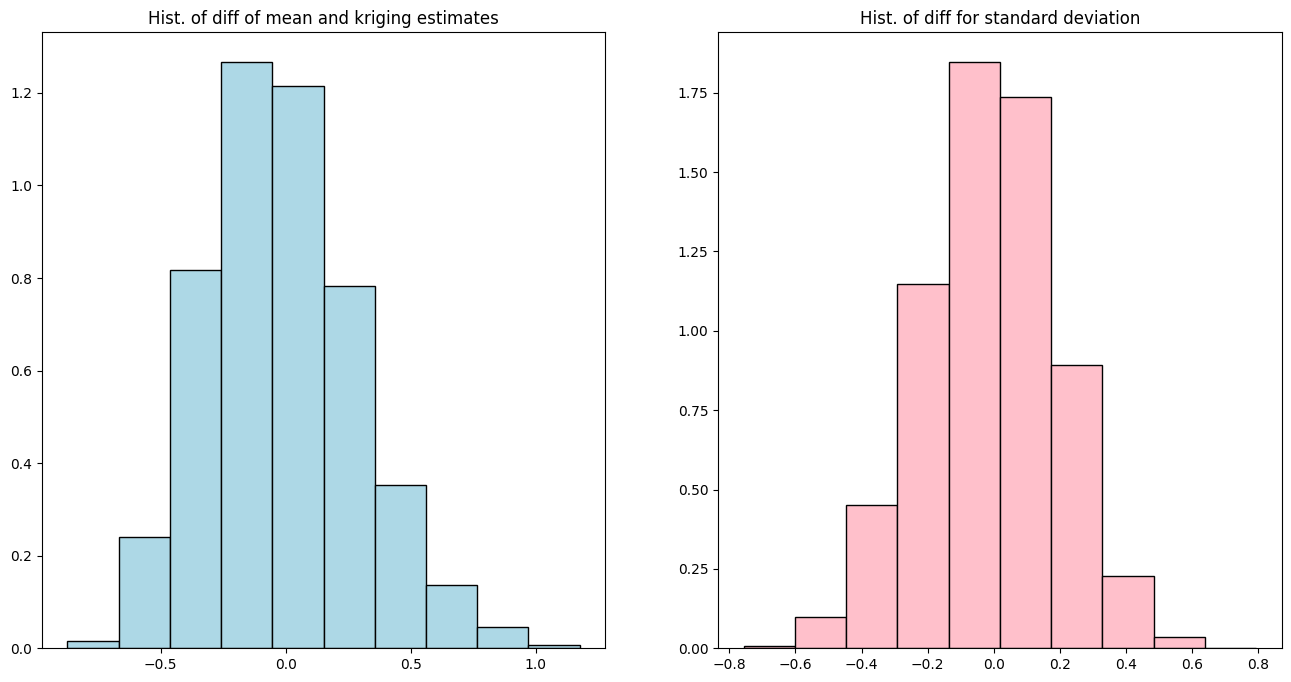

In [27]:
plt.subplots(1, 2, figsize=(16,8))

# Histogram of mean of all real - kriging estimates
plt.subplot(1, 2, 1)
plt.hist(sim3Db_mean_img.val.reshape(-1) - krig3Db_img.val[0].reshape(-1), 
         density=True, color='lightblue', edgecolor='black')
plt.title('Hist. of diff of mean and kriging estimates')

# Histogram of std of all real - kriging std
# kriging standard deviation
plt.subplot(1, 2, 2)
plt.hist(sim3Db_std_img.val.reshape(-1) - krig3Db_img.val[1].reshape(-1), 
         density=True, color='pink', edgecolor='black')
plt.title('Hist. of diff for standard deviation')

plt.show()

## Imposing mean and/or variance
Mean and variance in the simulation grid can be specified, they can be stationary (constant) or non-stationary. 
By default, the mean is set to the mean of data values (or zero if no conditioning data) (constant) and the variance is given by the sill of the variogram model (constant).



## Case C - Constant mean and variance
Set mean to $3.0$ and variance to the double of the covariance model sill. (Use the same data as above.)

### Simulation - case C
Set the number of realizations, the seed and launch the simulations.

In [28]:
nreal = 100
np.random.seed(123)
t1 = time.time() # start time
sim3Dc = gn.grf.grf3D(cov_model, dimension, spacing, origin, x=x, v=v, 
                      mean=3., var=2*cov_model.sill(), nreal=nreal)
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

# Fill image with result, and compute statistics
sim3Dc_img = gn.img.Img(nx, ny, nz, sx, sy, sz, ox, oy, oz, nv=nreal, val=sim3Dc)
del(sim3Dc)
sim3Dc_mean_img = gn.img.imageContStat(sim3Dc_img, op='mean') # pixel-wise mean
sim3Dc_std_img = gn.img.imageContStat(sim3Dc_img, op='std')   # pixel-wise standard deviation

Elapsed time: 9.9 sec


In [29]:
# %%script false --no-raise-error # skip this cell! (comment this line to run the cell)

# Alternative:
np.random.seed(123)
t1 = time.time() # start time
out = gn.multiGaussian.multiGaussianRun(cov_model, dimension, spacing, origin, 
                                        x=x, v=v,
                                        mean=3., var=2*cov_model.sill(),
                                        mode='simulation', algo='fft', output_mode='array',
                                        nreal=nreal)
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

# Same results:
print(f'Same results ? {np.allclose(out, sim3Dc_img.val[:, :, :, :])}') # should be True

grf3D: Preliminary computation...
grf3D: Computing circulant embedding...
grf3D: embedding dimension: 128 x 128 x 64
grf3D: Computing FFT of circulant matrix...
grf3D: Treatment of conditioning data...
grf3D: Computing covariance matrix (rAA) for conditioning locations...
grf3D: Computing index in the embedding grid for non-conditioning / conditioning locations...
Elapsed time: 10 sec
Same results ? True


### Kriging - case C
Compute (simple) kriging estimates and standard deviation.

In [30]:
t1 = time.time() # start time
krig3Dc, krig3Dc_std = gn.grf.krige3D(cov_model, dimension, spacing, origin, x=x, v=v,
                                      mean=3., var=2*cov_model.sill())
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

# Fill an image with two variables : kriging estimates and kriging std
krig3Dc_img = gn.img.Img(nx, ny, nz, sx, sy, sz, ox, oy, oz, nv=2, val=np.array((krig3Dc, krig3Dc_std)))
del(krig3Dc, krig3Dc_std)


Elapsed time: 0.3 sec


In [31]:
# %%script false --no-raise-error # skip this cell! (comment this line to run the cell)

# Alternative:
t1 = time.time() # start time
np.random.seed(123)
out = gn.multiGaussian.multiGaussianRun(cov_model, dimension, spacing, origin,
                                        x=x, v=v,
                                        mean=3., var=2*cov_model.sill(),
                                        mode='estimation', algo='fft', output_mode='array')
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

# Same results:
print(f'Same results ? {np.allclose(out, krig3Dc_img.val[:, :, :, :])}') # should be True

krige3D: Computing circulant embedding...
krige3D: embedding dimension: 128 x 128 x 64
krige3D: Computing FFT of circulant matrix...
krige3D: Computing covariance matrix (rAA) for conditioning locations...
krige3D: Computing covariance matrix (rBA) for non-conditioning / conditioning locations...
krige3D: Computing rBA * rAA^(-1)...
krige3D: computing kriging estimates...
krige3D: computing kriging standard deviation ...
Elapsed time: 0.31 sec
Same results ? True


### Plot results - case C

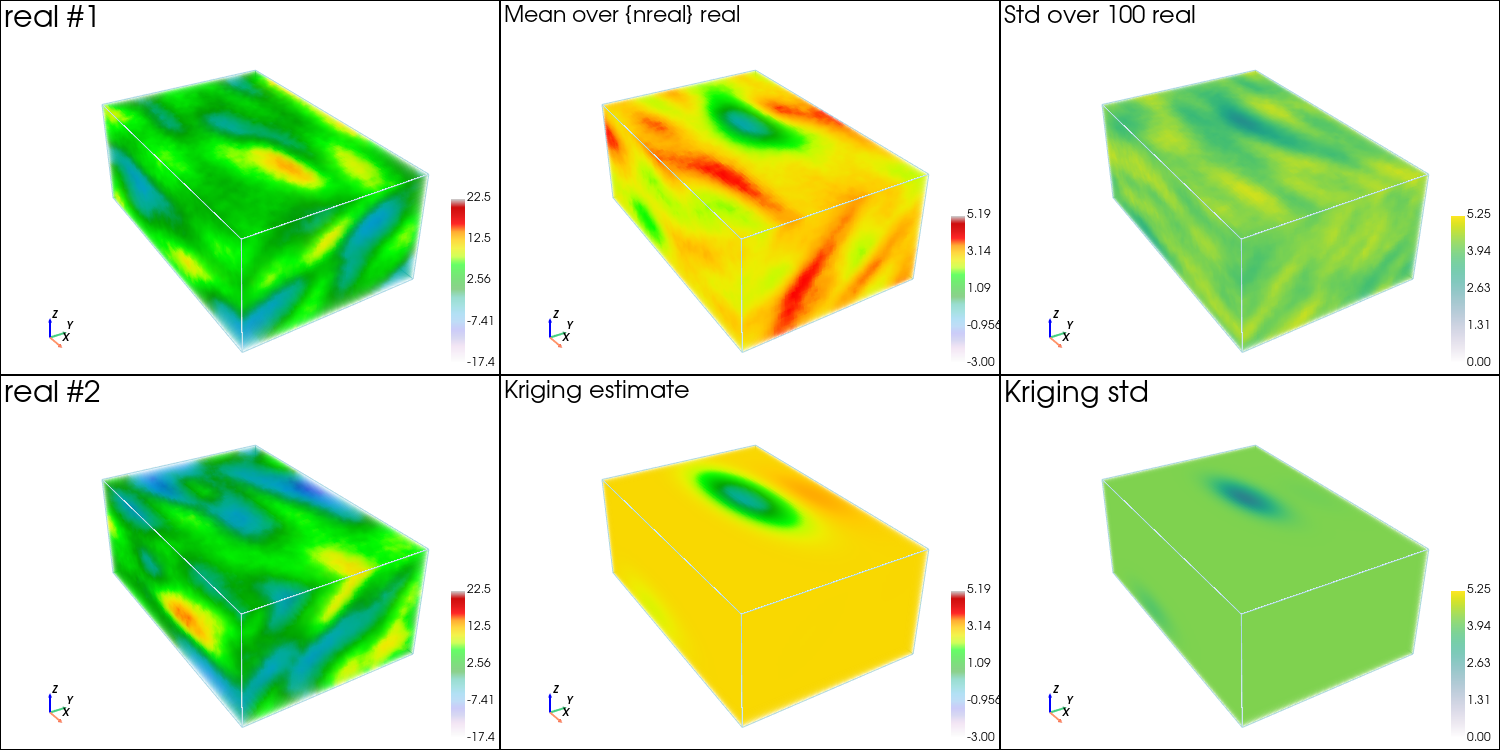

In [32]:
# Color settings
cmap = 'nipy_spectral'
cmin = sim3Dc_img.val.min()
cmax = sim3Dc_img.val.max()

cmap_mean = 'nipy_spectral'
cmin_mean = min(sim3Dc_mean_img.val.min(), krig3Dc_img.val[0].min())
cmax_mean = max(sim3Dc_mean_img.val.max(), krig3Dc_img.val[0].max())

cmap_std = 'viridis'
cmin_std = min(sim3Dc_std_img.val.min(), krig3Dc_img.val[1].min())
cmax_std = max(sim3Dc_std_img.val.max(), krig3Dc_img.val[1].max())

# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(2, 3), window_size=(1500, 750), notebook=False)
# ... inline
pp = pv.Plotter(shape=(2, 3), window_size=(1500, 750))

# 2 first reals
for i in (0, 1):
    pp.subplot(i, 0)
    gn.imgplot3d.drawImage3D_volume(
        sim3Dc_img, iv=i, 
        plotter=pp,
        cmap=cmap, cmin=cmin, cmax=cmax,
        text=f'real #{i+1}',
        text_kwargs={'font_size':12},
        scalar_bar_kwargs={'title':i*' ', 'vertical':True, 'label_font_size':12})
        # note: scalar bar title : set new one for each plot to show the scalar bar...

# mean of all real
pp.subplot(0, 1)
gn.imgplot3d.drawImage3D_volume(
    sim3Dc_mean_img, 
    plotter=pp,
    cmap=cmap_mean, cmin=cmin_mean, cmax=cmax_mean,
    text='Mean over {nreal} real',
    text_kwargs={'font_size':12},
    scalar_bar_kwargs={'title':2*' ', 'vertical':True, 'label_font_size':12})

# standard deviation of all real
pp.subplot(0, 2)
gn.imgplot3d.drawImage3D_volume(
    sim3Dc_std_img, 
    plotter=pp,
    cmap=cmap_std, cmin=cmin_std, cmax=cmax_std,
    text=f'Std over {nreal} real',
    text_kwargs={'font_size':12},
    scalar_bar_kwargs={'title':3*' ', 'vertical':True, 'label_font_size':12})

# kriging estimate
pp.subplot(1, 1)
gn.imgplot3d.drawImage3D_volume(
    krig3Dc_img, iv=0, 
    plotter=pp,
    cmap=cmap_mean, cmin=cmin_mean, cmax=cmax_mean,
    text=f'Kriging estimate',
    text_kwargs={'font_size':12},
    scalar_bar_kwargs={'title':4*' ', 'vertical':True, 'label_font_size':12})

# kriging std
pp.subplot(1, 2)
gn.imgplot3d.drawImage3D_volume(
    krig3Dc_img, iv=1, 
    plotter=pp,
    cmap=cmap_std, cmin=cmin_std, cmax=cmax_std,
    text=f'Kriging std',
    text_kwargs={'font_size':12},
    scalar_bar_kwargs={'title':5*' ', 'vertical':True, 'label_font_size':12})

pp.link_views()

cpos = pp.show(cpos=(165, -100, 115), return_cpos=True) # position of the camera can be specified

Plot slices orthogonal to each axis x, y, z, ang going through the first data point, and plot the data points.

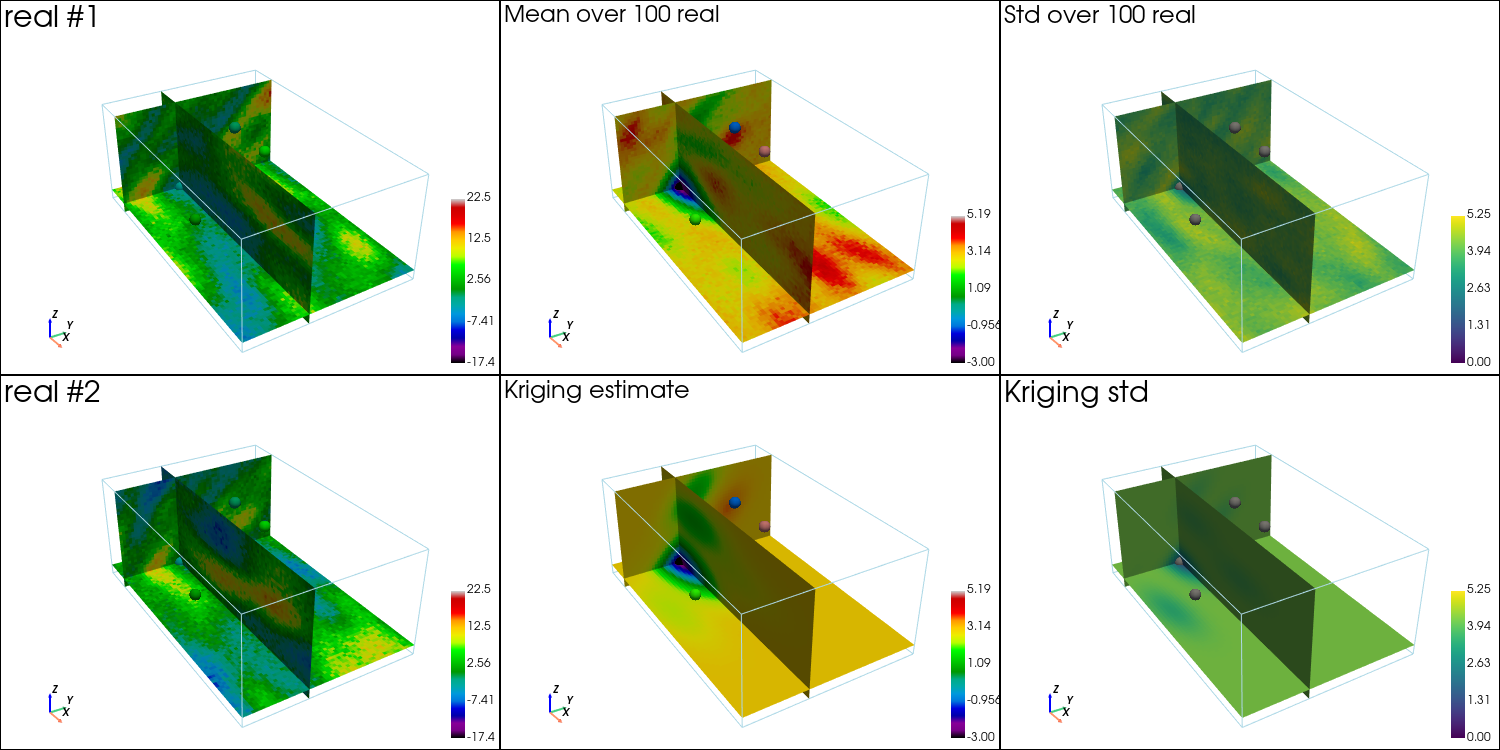

In [33]:
# Plot slices (with data points)
# ------------------------------
# # Color settings
# cmap = 'nipy_spectral'
# cmin = sim3Dc_img.val.min()
# cmax = sim3Dc_img.val.max()

# cmap_mean = 'nipy_spectral'
# cmin_mean = min(sim3Dc_mean_img.val.min(), krig3Dc_img.val[0].min())
# cmax_mean = max(sim3Dc_mean_img.val.max(), krig3Dc_img.val[0].max())

# cmap_std = 'viridis'
# cmin_std = min(sim3Dc_std_img.val.min(), krig3Dc_img.val[1].min())
# cmax_std = max(sim3Dc_std_img.val.max(), krig3Dc_img.val[1].max())

# Settings for plotting data
if x is not None:
    # Get colors for conditioning data according to their value and color settings
    data_points_col      = gn.imgplot.get_colors_from_values(v, cmap=cmap, cmin=cmin, cmax=cmax) 
    data_points_mean_col = gn.imgplot.get_colors_from_values(v, cmap=cmap_mean, cmin=cmin_mean, cmax=cmax_mean) 

    # Set points to be plotted
    data_points = pv.PolyData(x)
    data_points['colors'] = data_points_col

    data_points_mean = pv.PolyData(x)
    data_points_mean['colors'] = data_points_mean_col

    # Set slices through data of index j
    j = 0
    slice_normal_x = x[j,0]
    slice_normal_y = x[j,1]
    slice_normal_z = x[j,2]
else:
    # Set default slices
    slice_normal_x = sim3Db_img.x()[int(0.2*nx)]
    slice_normal_y = sim3Db_img.y()[int(0.8*ny)]
    slice_normal_z = sim3Db_img.z()[int(0.2*nz)]

# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(2, 3), window_size=(1500, 750), notebook=False)
# ... inline
pp = pv.Plotter(shape=(2, 3), window_size=(1500, 750))

# 2 first reals
for i in (0, 1):
    pp.subplot(i, 0)
    gn.imgplot3d.drawImage3D_slice(
        sim3Dc_img, iv=i, 
        plotter=pp,
        slice_normal_x=slice_normal_x,
        slice_normal_y=slice_normal_y,
        slice_normal_z=slice_normal_z,
        cmap=cmap, cmin=cmin, cmax=cmax,
        text=f'real #{i+1}',
        text_kwargs={'font_size':12},
        scalar_bar_kwargs={'title':i*' ', 'vertical':True, 'label_font_size':12})
        # note: scalar bar title : set new one for each plot to show the scalar bar...
    if x is not None:
        pp.add_mesh(data_points, rgb=True, point_size=12., render_points_as_spheres=True) # add data points

# mean of all real
pp.subplot(0, 1)
gn.imgplot3d.drawImage3D_slice(
    sim3Dc_mean_img, 
    plotter=pp,
    slice_normal_x=slice_normal_x,
    slice_normal_y=slice_normal_y,
    slice_normal_z=slice_normal_z,
    cmap=cmap_mean, cmin=cmin_mean, cmax=cmax_mean,
    text=f'Mean over {nreal} real',
    text_kwargs={'font_size':12},
    scalar_bar_kwargs={'title':2*' ', 'vertical':True, 'label_font_size':12})
if x is not None:
    pp.add_mesh(data_points_mean, rgb=True, point_size=12., render_points_as_spheres=True) # add data points

# standard deviation of all real
pp.subplot(0, 2)
gn.imgplot3d.drawImage3D_slice(
    sim3Dc_std_img, 
    plotter=pp,
    slice_normal_x=slice_normal_x,
    slice_normal_y=slice_normal_y,
    slice_normal_z=slice_normal_z,
    cmap=cmap_std, cmin=cmin_std, cmax=cmax_std,
    text=f'Std over {nreal} real',
    text_kwargs={'font_size':12},
    scalar_bar_kwargs={'title':3*' ', 'vertical':True, 'label_font_size':12})
if x is not None:
    pp.add_mesh(data_points, color='gray', point_size=12., render_points_as_spheres=True) # add data points

# kriging estimate
pp.subplot(1, 1)
gn.imgplot3d.drawImage3D_slice(
    krig3Dc_img, iv=0, 
    plotter=pp,
    slice_normal_x=slice_normal_x,
    slice_normal_y=slice_normal_y,
    slice_normal_z=slice_normal_z,
    cmap=cmap_mean, cmin=cmin_mean, cmax=cmax_mean,
    text=f'Kriging estimate',
    text_kwargs={'font_size':12},
    scalar_bar_kwargs={'title':4*' ', 'vertical':True, 'label_font_size':12})
if x is not None:
    pp.add_mesh(data_points_mean, rgb=True, point_size=12., render_points_as_spheres=True) # add data points

# kriging std
pp.subplot(1, 2)
gn.imgplot3d.drawImage3D_slice(
    krig3Dc_img, iv=1, 
    plotter=pp,
    slice_normal_x=slice_normal_x,
    slice_normal_y=slice_normal_y,
    slice_normal_z=slice_normal_z,
    cmap=cmap_std, cmin=cmin_std, cmax=cmax_std,
    text=f'Kriging std',
    text_kwargs={'font_size':12},
    scalar_bar_kwargs={'title':5*' ', 'vertical':True, 'label_font_size':12})
if x is not None:
    pp.add_mesh(data_points, color='gray', point_size=12., render_points_as_spheres=True) # add data points

pp.link_views()

cpos = pp.show(cpos=(165, -100, 115), return_cpos=True) # position of the camera can be specified

### Comparison of mean and standard deviation of all realizations with kriging results - case C

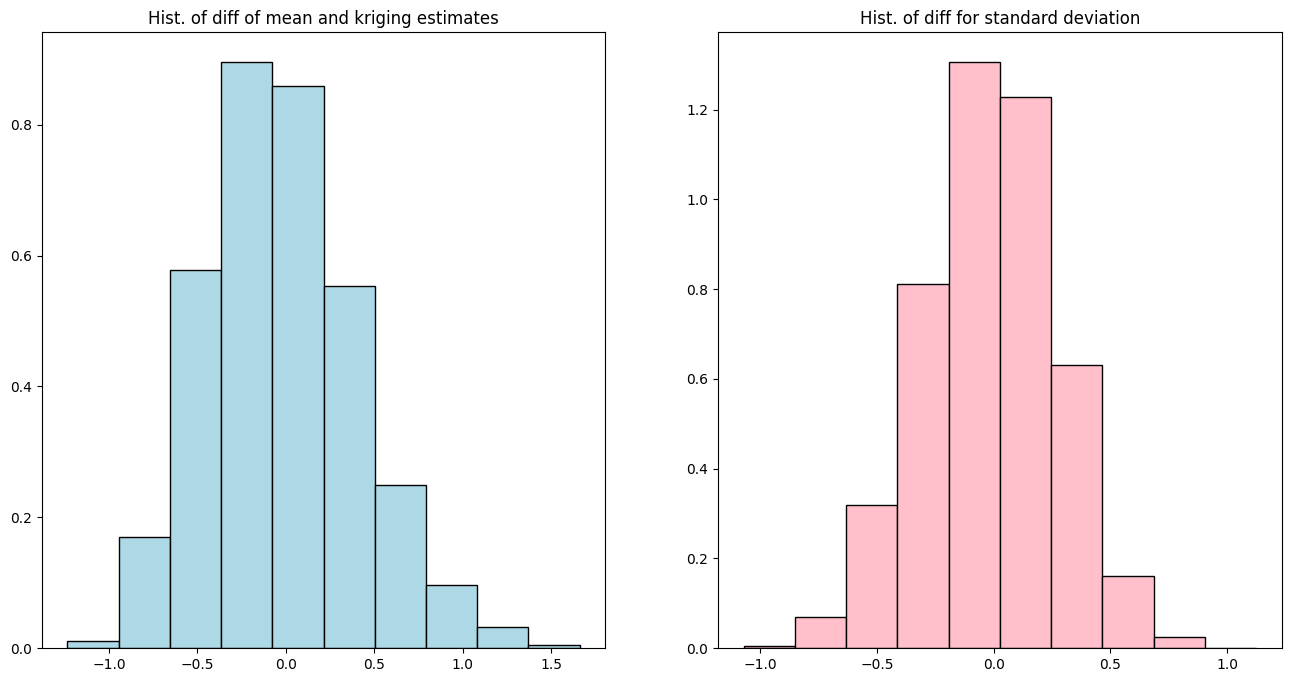

In [34]:
plt.subplots(1, 2, figsize=(16,8))

# Histogram of mean of all real - kriging estimates
plt.subplot(1, 2, 1)
plt.hist(sim3Dc_mean_img.val.reshape(-1) - krig3Dc_img.val[0].reshape(-1), 
         density=True, color='lightblue', edgecolor='black')
plt.title('Hist. of diff of mean and kriging estimates')

# Histogram of std of all real - kriging std
# kriging standard deviation
plt.subplot(1, 2, 2)
plt.hist(sim3Dc_std_img.val.reshape(-1) - krig3Dc_img.val[1].reshape(-1), 
         density=True, color='pink', edgecolor='black')
plt.title('Hist. of diff for standard deviation')

plt.show()


## Case D - Non-stationary mean and variance
Set a varying mean and a varying variance over the simulation domain.

In [35]:
# Set an image with simulation grid geometry defined above, and no variable
im = gn.img.Img(nx, ny, nz, sx, sy, sz, ox, oy, oz, nv=0)

# Get the x, y, z coordinates of the centers of grid cell (meshgrid)
xx = im.xx()
yy = im.yy()
zz = im.zz()

# Define the mean and variance on the simulation grid
mean = 0.1*(zz + yy - xx)         # define mean on the simulation grid
var = 1 + 0.1*(xx + yy + zz)      # define variance on the simulation grid


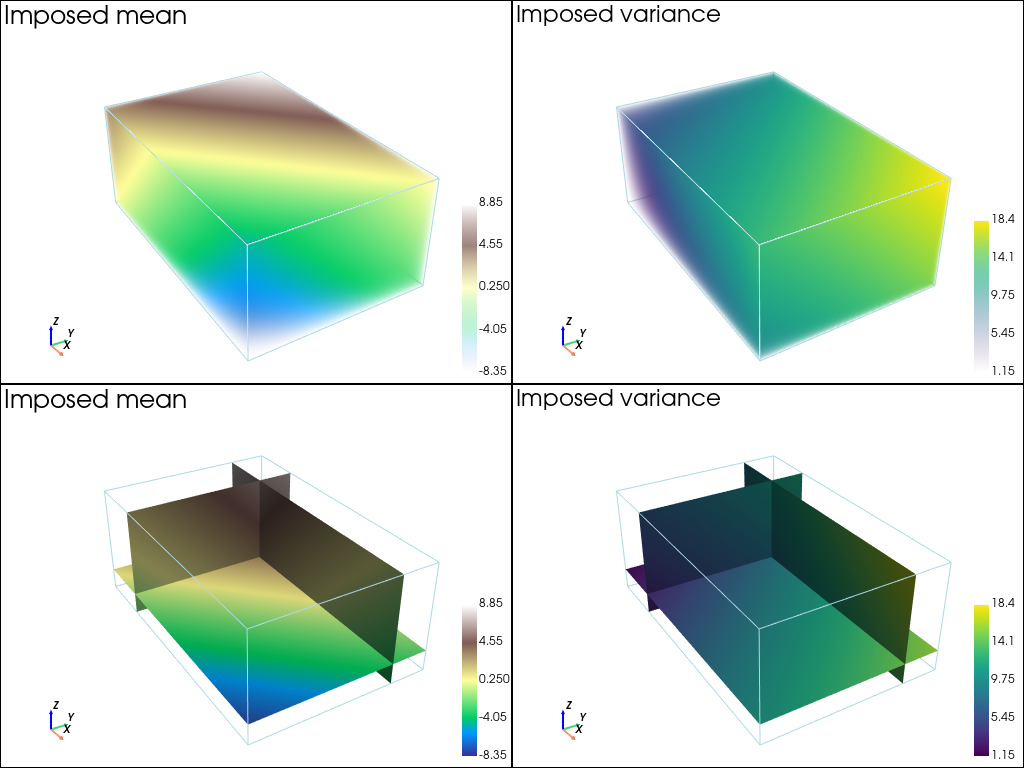

In [36]:
# Plot mean and var
# -----------------
# Set variable mean and var in image im
im.append_var([mean, var], varname=['mean', 'var'])

# Display imposed mean and var
# Color settings
cmap = 'terrain'

# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(2,2), notebook=False)
# ... inline
pp = pv.Plotter(shape=(2,2))

# mean (3d)
pp.subplot(0, 0)
gn.imgplot3d.drawImage3D_volume(
    im, iv=0, 
    plotter=pp,
    cmap=cmap, 
    text='Imposed mean',
    text_kwargs={'font_size':12},
    scalar_bar_kwargs={'title':0*' ', 'vertical':True, 'label_font_size':12})

# var
pp.subplot(0, 1)
gn.imgplot3d.drawImage3D_volume(
    im, iv=1, 
    plotter=pp,
    cmap='viridis', 
    text='Imposed variance',
    text_kwargs={'font_size':12},
    scalar_bar_kwargs={'title':1*' ', 'vertical':True, 'label_font_size':12})

# Set slices
slice_normal_x = im.x()[int(0.2*nx)]
slice_normal_y = im.y()[int(0.8*ny)]
slice_normal_z = im.z()[int(0.2*nz)]

# mean
pp.subplot(1, 0)
gn.imgplot3d.drawImage3D_slice(
    im, iv=0, 
    plotter=pp,
    slice_normal_x=slice_normal_x,
    slice_normal_y=slice_normal_y,
    slice_normal_z=slice_normal_z,
    cmap=cmap,
    text='Imposed mean',
    text_kwargs={'font_size':12},
    scalar_bar_kwargs={'title':3*' ', 'vertical':True, 'label_font_size':12})

# var
pp.subplot(1, 1)
gn.imgplot3d.drawImage3D_slice(
    im, iv=1, 
    plotter=pp,
    slice_normal_x=slice_normal_x,
    slice_normal_y=slice_normal_y,
    slice_normal_z=slice_normal_z,
    cmap='viridis', 
    text='Imposed variance',
    text_kwargs={'font_size':12},
    scalar_bar_kwargs={'title':4*' ', 'vertical':True, 'label_font_size':12})

pp.link_views()

cpos = pp.show(cpos=(165, -100, 115), return_cpos=True) # position of the camera can be specified

### Simulation - case D
Set the number of realizations, the seed and launch the simulations.

In [37]:
nreal = 100
np.random.seed(123)
t1 = time.time() # start time
sim3Dd = gn.grf.grf3D(cov_model, dimension, spacing, origin, x=x, v=v, 
                      mean=mean, var=var, nreal=nreal)
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

# Fill image with result, and compute statistics
sim3Dd_img = gn.img.Img(nx, ny, nz, sx, sy, sz, ox, oy, oz, nv=nreal, val=sim3Dd)
del(sim3Dd)
sim3Dd_mean_img = gn.img.imageContStat(sim3Dd_img, op='mean') # pixel-wise mean
sim3Dd_std_img = gn.img.imageContStat(sim3Dd_img, op='std')   # pixel-wise standard deviation

Elapsed time: 9.9 sec


In [38]:
# %%script false --no-raise-error # skip this cell! (comment this line to run the cell)

# Alternative:
np.random.seed(123)
t1 = time.time() # start time
out = gn.multiGaussian.multiGaussianRun(cov_model, dimension, spacing, origin, 
                                        x=x, v=v,
                                        mean=mean, var=var,
                                        mode='simulation', algo='fft', output_mode='array',
                                        nreal=nreal)
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

# Same results:
print(f'Same results ? {np.allclose(out, sim3Dd_img.val[:, :, :, :])}') # should be True

grf3D: Preliminary computation...
grf3D: Computing circulant embedding...
grf3D: embedding dimension: 128 x 128 x 64
grf3D: Computing FFT of circulant matrix...
grf3D: Treatment of conditioning data...
grf3D: Computing covariance matrix (rAA) for conditioning locations...
grf3D: Computing index in the embedding grid for non-conditioning / conditioning locations...
Elapsed time: 8.6 sec
Same results ? True


### Kriging - case D
Compute (simple) kriging estimates and standard deviation.

In [39]:
t1 = time.time() # start time
krig3Dd, krig3Dd_std = gn.grf.krige3D(cov_model, dimension, spacing, origin, x=x, v=v,
                                      mean=mean, var=var)
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

# Fill an image with two variables : kriging estimates and kriging std
krig3Dd_img = gn.img.Img(nx, ny, nz, sx, sy, sz, ox, oy, oz, nv=2, val=np.array((krig3Dd, krig3Dd_std)))
del(krig3Dd, krig3Dd_std)


Elapsed time: 0.31 sec


In [40]:
# %%script false --no-raise-error # skip this cell! (comment this line to run the cell)

# Alternative:
t1 = time.time() # start time
np.random.seed(123)
out = gn.multiGaussian.multiGaussianRun(cov_model, dimension, spacing, origin,
                                        x=x, v=v,
                                        mean=mean, var=var,
                                        mode='estimation', algo='fft', output_mode='array')
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

# Same results:
print(f'Same results ? {np.allclose(out, krig3Dd_img.val[:, :, :, :])}') # should be True

krige3D: Computing circulant embedding...
krige3D: embedding dimension: 128 x 128 x 64
krige3D: Computing FFT of circulant matrix...
krige3D: Computing covariance matrix (rAA) for conditioning locations...
krige3D: Computing covariance matrix (rBA) for non-conditioning / conditioning locations...
krige3D: Computing rBA * rAA^(-1)...
krige3D: computing kriging estimates...
krige3D: computing kriging standard deviation ...
Elapsed time: 0.33 sec
Same results ? True


### Plot results - case D

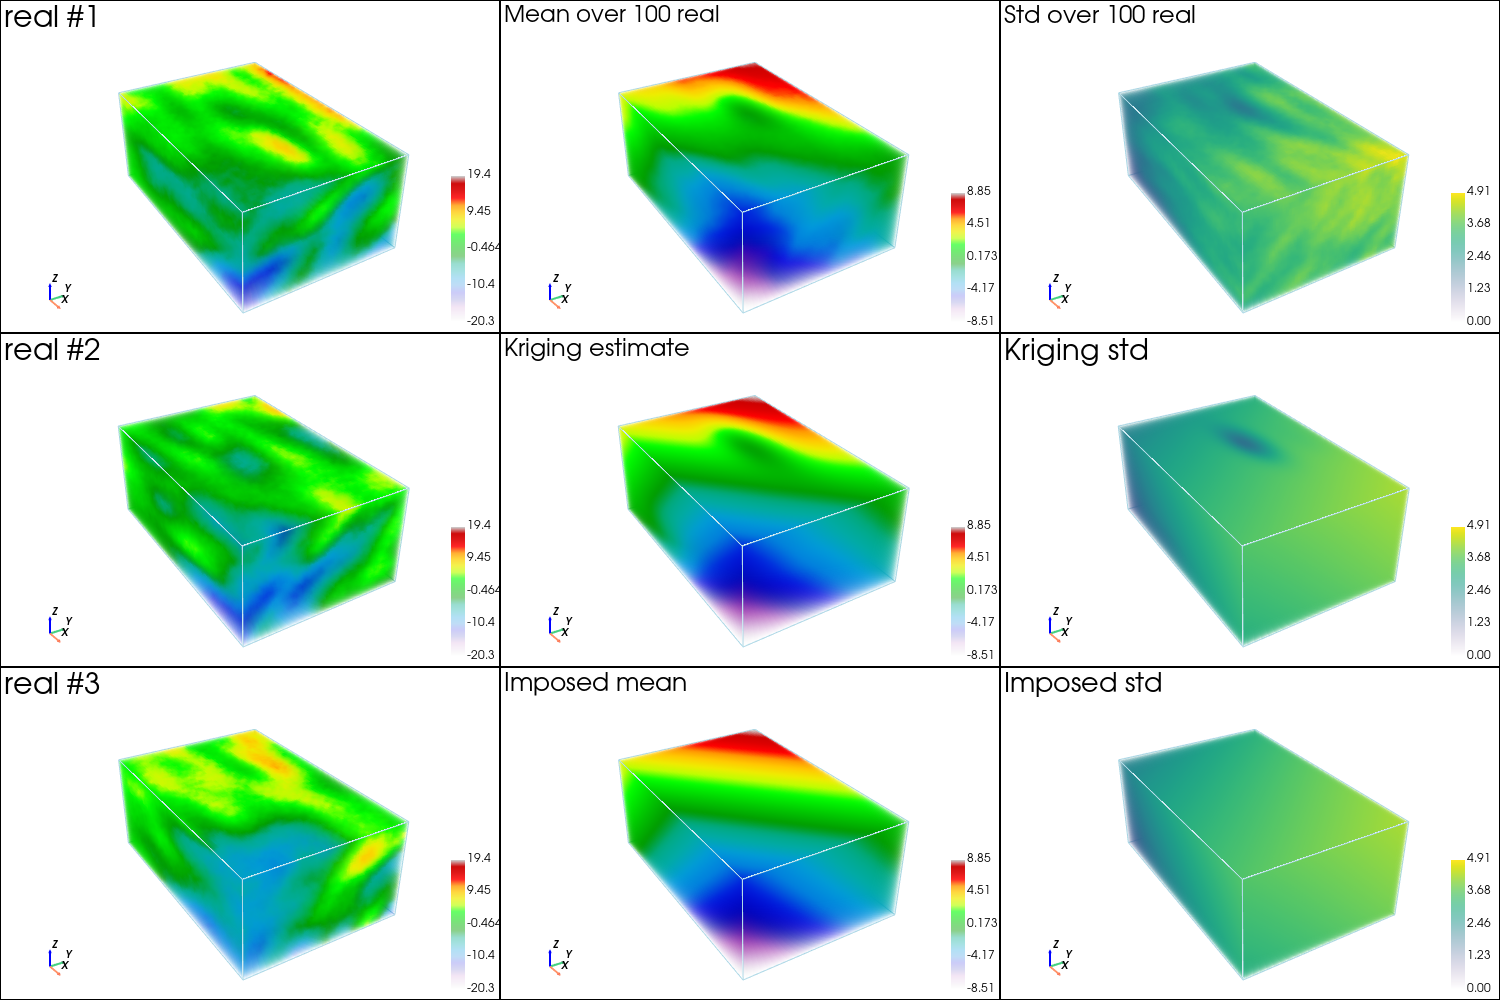

In [41]:
im_mean = gn.img.Img(nx, ny, nz, sx, sy, sz, ox, oy, oz, nv=1, val=im.val[0])
im_std = gn.img.Img(nx, ny, nz, sx, sy, sz, ox, oy, oz, nv=1, val=np.sqrt(im.val[1]))

# Color settings
cmap = 'nipy_spectral'
cmin = sim3Dd_img.val.min()
cmax = sim3Dd_img.val.max()

cmap_mean = 'nipy_spectral'
cmin_mean = min(sim3Dd_mean_img.val.min(), krig3Dd_img.val[0].min(), im_mean.val.min())
cmax_mean = max(sim3Dd_mean_img.val.max(), krig3Dd_img.val[0].max(), im_mean.val.max())

cmap_std = 'viridis'
cmin_std = min(sim3Dd_std_img.val.min(), krig3Dd_img.val[1].min(), im_std.val.min())
cmax_std = max(sim3Dd_std_img.val.max(), krig3Dd_img.val[1].max(), im_std.val.max())

# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(3, 3), window_size=(1500, 1000), notebook=False)
# ... inline
pp = pv.Plotter(shape=(3, 3), window_size=(1500, 1000))

# 3 first reals
for i in (0, 1, 2):
    pp.subplot(i, 0)
    gn.imgplot3d.drawImage3D_volume(
        sim3Dd_img, iv=i, 
        plotter=pp,
        cmap=cmap, cmin=cmin, cmax=cmax,
        text=f'real #{i+1}',
        text_kwargs={'font_size':12},
        scalar_bar_kwargs={'title':i*' ', 'vertical':True, 'label_font_size':12})
        # note: scalar bar title : set new one for each plot to show the scalar bar...

# mean of all real
pp.subplot(0, 1)
gn.imgplot3d.drawImage3D_volume(
    sim3Dd_mean_img, 
    plotter=pp,
    cmap=cmap_mean, cmin=cmin_mean, cmax=cmax_mean,
    text=f'Mean over {nreal} real',
    text_kwargs={'font_size':12},
    scalar_bar_kwargs={'title':3*' ', 'vertical':True, 'label_font_size':12})

# standard deviation of all real
pp.subplot(0, 2)
gn.imgplot3d.drawImage3D_volume(
    sim3Dd_std_img, 
    plotter=pp,
    cmap=cmap_std, cmin=cmin_std, cmax=cmax_std,
    text=f'Std over {nreal} real',
    text_kwargs={'font_size':12},
    scalar_bar_kwargs={'title':4*' ', 'vertical':True, 'label_font_size':12})

# kriging estimate
pp.subplot(1, 1)
gn.imgplot3d.drawImage3D_volume(
    krig3Dd_img, iv=0, 
    plotter=pp,
    cmap=cmap_mean, cmin=cmin_mean, cmax=cmax_mean,
    text=f'Kriging estimate',
    text_kwargs={'font_size':12},
    scalar_bar_kwargs={'title':5*' ', 'vertical':True, 'label_font_size':12})

# kriging std
pp.subplot(1, 2)
gn.imgplot3d.drawImage3D_volume(
    krig3Dd_img, iv=1, 
    plotter=pp,
    cmap=cmap_std, cmin=cmin_std, cmax=cmax_std,
    text=f'Kriging std',
    text_kwargs={'font_size':12},
    scalar_bar_kwargs={'title':6*' ', 'vertical':True, 'label_font_size':12})

# Imposed mean
pp.subplot(2, 1)
gn.imgplot3d.drawImage3D_volume(
    im_mean, iv=0, 
    plotter=pp,
    cmap=cmap_mean, cmin=cmin_mean, cmax=cmax_mean,
    text=f'Imposed mean',
    text_kwargs={'font_size':12},
    scalar_bar_kwargs={'title':7*' ', 'vertical':True, 'label_font_size':12})

# Imposed std
pp.subplot(2, 2)
gn.imgplot3d.drawImage3D_volume(
    im_std, iv=0, 
    plotter=pp,
    cmap=cmap_std, cmin=cmin_std, cmax=cmax_std,
    text=f'Imposed std',
    text_kwargs={'font_size':12},
    scalar_bar_kwargs={'title':8*' ', 'vertical':True, 'label_font_size':12})

pp.link_views()

cpos = pp.show(cpos=(165, -100, 115), return_cpos=True) # position of the camera can be specified

Plot slices orthogonal to each axis x, y, z, ang going through the first data point, and plot the data points.

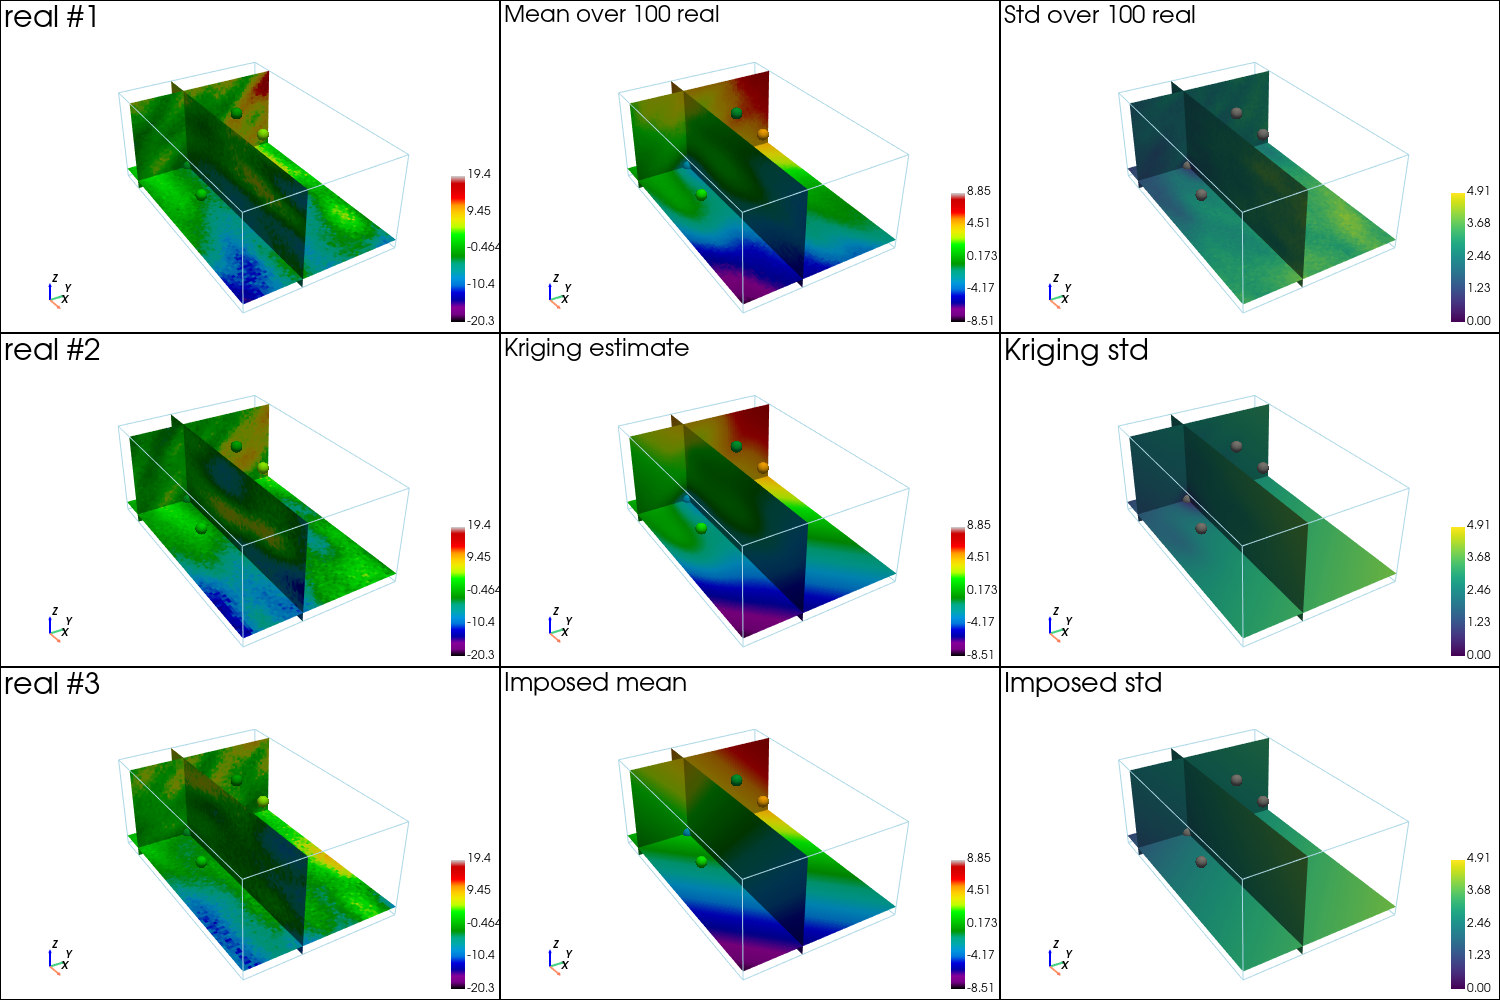

In [42]:
# Plot slices (with data points)
# ------------------------------
# # Color settings
# cmap = 'nipy_spectral'
# cmin = sim3Dd_img.val.min()
# cmax = sim3Dd_img.val.max()

# cmap_mean = 'nipy_spectral'
# cmin_mean = min(sim3Dd_mean_img.val.min(), krig3Dd_img.val[0].min(), im_mean.val.min())
# cmax_mean = max(sim3Dd_mean_img.val.max(), krig3Dd_img.val[0].max(), im_mean.val.max())

# cmap_std = 'viridis'
# cmin_std = min(sim3Dd_std_img.val.min(), krig3Dd_img.val[1].min(), im_std.val.min())
# cmax_std = max(sim3Dd_std_img.val.max(), krig3Dd_img.val[1].max(), im_std.val.max())

# Settings for plotting data
if x is not None:
    # Get colors for conditioning data according to their value and color settings
    data_points_col      = gn.imgplot.get_colors_from_values(v, cmap=cmap, cmin=cmin, cmax=cmax) 
    data_points_mean_col = gn.imgplot.get_colors_from_values(v, cmap=cmap_mean, cmin=cmin_mean, cmax=cmax_mean) 

    # Set points to be plotted
    data_points = pv.PolyData(x)
    data_points['colors'] = data_points_col

    data_points_mean = pv.PolyData(x)
    data_points_mean['colors'] = data_points_mean_col

    # Set slices through data of index j
    j = 0
    slice_normal_x = x[j,0]
    slice_normal_y = x[j,1]
    slice_normal_z = x[j,2]
else:
    # Set default slices
    slice_normal_x = sim3Dd_img.x()[int(0.2*nx)]
    slice_normal_y = sim3Dd_img.y()[int(0.8*ny)]
    slice_normal_z = sim3Dd_img.z()[int(0.2*nz)]

# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(3, 3), window_size=(1500, 1000), notebook=False)
# ... inline
pp = pv.Plotter(shape=(3, 3), window_size=(1500, 1000))

# 3 first reals
for i in (0, 1, 2):
    pp.subplot(i, 0)
    gn.imgplot3d.drawImage3D_slice(
        sim3Dd_img, iv=i, 
        plotter=pp,
        slice_normal_x=slice_normal_x,
        slice_normal_y=slice_normal_y,
        slice_normal_z=slice_normal_z,
        cmap=cmap, cmin=cmin, cmax=cmax,
        text=f'real #{i+1}',
        text_kwargs={'font_size':12},
        scalar_bar_kwargs={'title':i*' ', 'vertical':True, 'label_font_size':12})
        # note: scalar bar title : set new one for each plot to show the scalar bar...
    if x is not None:
        pp.add_mesh(data_points, rgb=True, point_size=12., render_points_as_spheres=True) # add data points

# mean of all real
pp.subplot(0, 1)
gn.imgplot3d.drawImage3D_slice(
    sim3Dd_mean_img, 
    plotter=pp,
    slice_normal_x=slice_normal_x,
    slice_normal_y=slice_normal_y,
    slice_normal_z=slice_normal_z,
    cmap=cmap_mean, cmin=cmin_mean, cmax=cmax_mean,
    text=f'Mean over {nreal} real',
    text_kwargs={'font_size':12},
    scalar_bar_kwargs={'title':3*' ', 'vertical':True, 'label_font_size':12})
if x is not None:
    pp.add_mesh(data_points_mean, rgb=True, point_size=12., render_points_as_spheres=True) # add data points

# standard deviation of all real
pp.subplot(0, 2)
gn.imgplot3d.drawImage3D_slice(
    sim3Dd_std_img, 
    plotter=pp,
    slice_normal_x=slice_normal_x,
    slice_normal_y=slice_normal_y,
    slice_normal_z=slice_normal_z,
    cmap=cmap_std, cmin=cmin_std, cmax=cmax_std,
    text=f'Std over {nreal} real',
    text_kwargs={'font_size':12},
    scalar_bar_kwargs={'title':4*' ', 'vertical':True, 'label_font_size':12})
if x is not None:
    pp.add_mesh(data_points, color='gray', point_size=12., render_points_as_spheres=True) # add data points

# kriging estimate
pp.subplot(1, 1)
gn.imgplot3d.drawImage3D_slice(
    krig3Dd_img, iv=0, 
    plotter=pp,
    slice_normal_x=slice_normal_x,
    slice_normal_y=slice_normal_y,
    slice_normal_z=slice_normal_z,
    cmap=cmap_mean, cmin=cmin_mean, cmax=cmax_mean,
    text=f'Kriging estimate',
    text_kwargs={'font_size':12},
    scalar_bar_kwargs={'title':5*' ', 'vertical':True, 'label_font_size':12})
if x is not None:
    pp.add_mesh(data_points_mean, rgb=True, point_size=12., render_points_as_spheres=True) # add data points

# kriging std
pp.subplot(1, 2)
gn.imgplot3d.drawImage3D_slice(
    krig3Dd_img, iv=1, 
    plotter=pp,
    slice_normal_x=slice_normal_x,
    slice_normal_y=slice_normal_y,
    slice_normal_z=slice_normal_z,
    cmap=cmap_std, cmin=cmin_std, cmax=cmax_std,
    text=f'Kriging std',
    text_kwargs={'font_size':12},
    scalar_bar_kwargs={'title':6*' ', 'vertical':True, 'label_font_size':12})
if x is not None:
    pp.add_mesh(data_points, color='gray', point_size=12., render_points_as_spheres=True) # add data points

# Imposed mean
pp.subplot(2, 1)
gn.imgplot3d.drawImage3D_slice(
    im_mean, iv=0, 
    plotter=pp,
    slice_normal_x=slice_normal_x,
    slice_normal_y=slice_normal_y,
    slice_normal_z=slice_normal_z,
    cmap=cmap_mean, cmin=cmin_mean, cmax=cmax_mean,
    text=f'Imposed mean',
    text_kwargs={'font_size':12},
    scalar_bar_kwargs={'title':7*' ', 'vertical':True, 'label_font_size':12})
if x is not None:
    pp.add_mesh(data_points_mean, rgb=True, point_size=12., render_points_as_spheres=True) # add data points

# Imposed std
pp.subplot(2, 2)
gn.imgplot3d.drawImage3D_slice(
    im_std, iv=0, 
    plotter=pp,
    slice_normal_x=slice_normal_x,
    slice_normal_y=slice_normal_y,
    slice_normal_z=slice_normal_z,
    cmap=cmap_std, cmin=cmin_std, cmax=cmax_std,
    text=f'Imposed std',
    text_kwargs={'font_size':12},
    scalar_bar_kwargs={'title':8*' ', 'vertical':True, 'label_font_size':12})
if x is not None:
    pp.add_mesh(data_points, color='gray', point_size=12., render_points_as_spheres=True) # add data points

pp.link_views()

cpos = pp.show(cpos=(165, -100, 115), return_cpos=True) # position of the camera can be specified

### Comparison of mean and standard deviation of all realizations with kriging results - case D

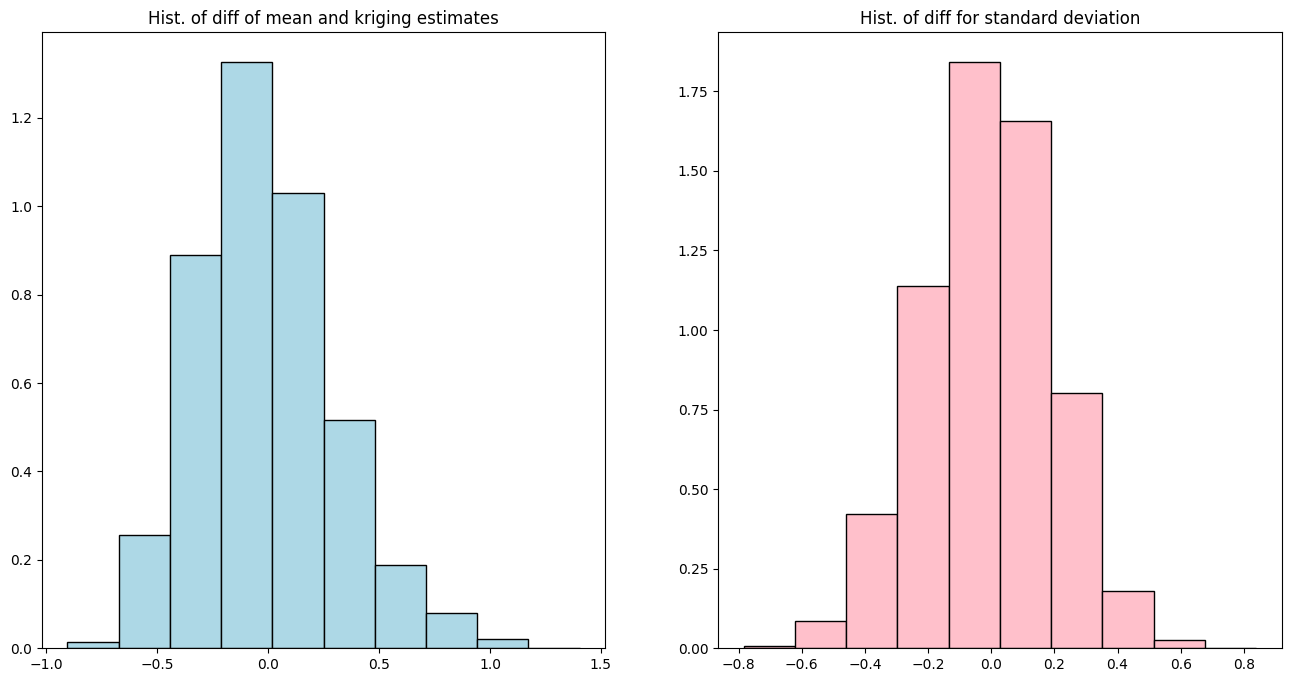

In [43]:
plt.subplots(1, 2, figsize=(16,8))

# Histogram of mean of all real - kriging estimates
plt.subplot(1, 2, 1)
plt.hist(sim3Dd_mean_img.val.reshape(-1) - krig3Dd_img.val[0].reshape(-1), 
         density=True, color='lightblue', edgecolor='black')
plt.title('Hist. of diff of mean and kriging estimates')

# Histogram of std of all real - kriging std
# kriging standard deviation
plt.subplot(1, 2, 2)
plt.hist(sim3Dd_std_img.val.reshape(-1) - krig3Dd_img.val[1].reshape(-1), 
         density=True, color='pink', edgecolor='black')
plt.title('Hist. of diff for standard deviation')

plt.show()